# **변수 모으기**

user_id 기반으로 유의미한 feature를 하나씩 모아보겠습니다. 다 합쳐서 써보죠 뭐.

# IMPORT & LOAD DATA

In [2]:
import load_dtypes as ld
import warnings
warnings.filterwarnings(action='ignore')

import os, sys
import time
import datetime as dt

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN

from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve, recall_score, precision_score

import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import StratifiedKFold

In [3]:
#-------------------------------------------------------------------------------------
# validation auc score를 확인하기 위해 정의
def f_pr_auc(probas_pred, y_true):
    labels=y_true.get_label()
    p, r, _ = precision_recall_curve(labels, probas_pred)
    score=auc(r,p) 
    return "pr_auc", score, True
#-------------------------------------------------------------------------------------

In [4]:
TRAIN_P_PATH = r'C:\Users\Wyatt\wyatt37/Data/systemError/train_problem_data.csv'
TRAIN_Q_PATH = r'C:\Users\Wyatt\wyatt37/Data/systemError/train_quality_data.csv'
TRAIN_E_PATH = r'C:\Users\Wyatt\wyatt37/Data/systemError/train_err_data.csv'
TEST_Q_PATH = r'C:\Users\Wyatt\wyatt37/Data/systemError/test_quality_data.csv'
TEST_E_PATH = r'C:\Users\Wyatt\wyatt37/Data/systemError/test_err_data.csv'
SUBMISSION_PATH = r'C:\Users\Wyatt\wyatt37/Data/systemError/sample_submission.csv'

In [5]:
%%time
train_p = ld.load_dtypes(TRAIN_P_PATH)
train_q = ld.load_dtypes(TRAIN_Q_PATH)
train_e = ld.load_dtypes(TRAIN_E_PATH)
test_q = ld.load_dtypes(TEST_Q_PATH)
test_e = ld.load_dtypes(TEST_E_PATH)
submission = pd.read_csv(SUBMISSION_PATH)

C:\Users\Wyatt\wyatt37/Data/systemError/train_problem_data.csv
C:\Users\Wyatt\wyatt37/Data/systemError/train_quality_data.csv
C:\Users\Wyatt\wyatt37/Data/systemError/train_err_data.csv
C:\Users\Wyatt\wyatt37/Data/systemError/test_quality_data.csv
C:\Users\Wyatt\wyatt37/Data/systemError/test_err_data.csv
Wall time: 1min 20s


In [6]:
train_p.shape, train_q.shape, train_e.shape, test_q.shape, test_e.shape, submission.shape

((5429, 2),
 (828624, 16),
 (16554663, 6),
 (747972, 16),
 (16532648, 6),
 (14999, 2))

In [7]:
def preprocessing_problem(df, object_='binary'):
    """
    definition:
    train_problem 테이블을 받아서 target 값으로 변환
    1. {0, 1}의 binary로 변환
    2. {0 ~ n}의 multiclass로 변환
    """
    
    # 10001부터 24999까지의 index를 만들어줍니다.
    user_id_idx = np.array(range(10000, 25000, 1))
    
    # train_new_p라는 새로운 df를 만들고 index는 위에서 만든 user_id_idx 로 지정해줍니다.
    new_p = pd.DataFrame(index = user_id_idx)
    new_p['target'] = 0
    
    if object_ == 'binary':
        new_p.iloc[df.user_id.unique()-10000] = 1
        new_p = new_p.reset_index()
        new_p.rename({'index':'user_id'}, axis=1, inplace=True)
        
    elif object_ == 'multi':
        # multi는 count()로 집계를 해줍니다.
        new_p['target'] = df.groupby('user_id')['time'].count()
        new_p = new_p.fillna(0)
        new_p = new_p.reset_index()
        new_p.rename({'index':'user_id'}, axis=1, inplace=True)
        
    return new_p

In [8]:
train_b_p = preprocessing_problem(train_p, 'binary')
train_m_p = preprocessing_problem(train_p, 'multi')

In [9]:
def preprocessing_quality(df):
    """
    definition:
    EDA를 통해 알아낸 정보로 train_q, test_q를 정리해서 내뿜어줍니다.
    1. qaulity_3, quality_4 를 drop 합니다.(단일 value)
    2. qaulity_k 변수들을 정수로 encoding 합니다.
    """
    # 먼저 3, 4번을 drop 합니다.
    df.drop(['quality_3', 'quality_4'], axis=1, inplace=True)
    
    # qual 변수만 할당해주고, 정수로 형변환 해줍니다.
    columns = train_q.columns[train_q.columns.str.contains('quality')]
    # for문을 통해 각 column을 반복 작업해줍니다.
    for col in columns:
        try:
            if df[col].dtype == 'float32': # 기존에 float은 패스
                df[col] = df[col].fillna(-2)
            elif df[col].dtype == 'int8' or df[col].dtype == 'int16': # 기존에 int도 패스
                df[col] = df[col].fillna(-2)
                #print(col)
            else:
                df[col] = df[col].astype('object')
                # nan값이 있으면 float으로 갈 수 없으니 '-2' 으로 채워줍니다.
                df[col] = df[col].fillna('-2')
                df[col] = df[col].apply(lambda x: x.replace(',' , ''))
                df[col] = df[col].astype(np.float32)
        except:
            pass
        
    # fwver 에서 null 값이 꽤 있습니다. missing으로 채우겠습니다.
    df.fwver = df.fwver.astype('object')
    df.fwver = df.fwver.fillna('missing')
    df.fwver = df.fwver.astype('category')
        
    return df

In [10]:
train_q = preprocessing_quality(train_q)
test_q = preprocessing_quality(test_q)

In [11]:
def preprocessing_fwver(df):
    """
    definition:
    별건 아니고, e-set에 fwver 변수에서 '10' 이라는 값이 있는데, 이게 errtype이랑 겹쳐요.
    그래서 10을 -> 8.5.2 으로 바꿔줄 겁니다.
    굳이 이렇게 바꾸는 이유는, 해당 fw가 8.5.3버전과 같은 model_nm을 공유하기 때문입니다.
    """
    df.fwver = df.fwver.replace('10', '8.5.2')
        
    return df

In [12]:
train_e = preprocessing_fwver(train_e)
test_e = preprocessing_fwver(test_e)

In [13]:
def make_datetime(df, column_name):
    """
    definition:
    'time' column이 str로 되어 있으니, datetime으로 바꿔주는 함수입니다.
    다만 'time'양식이 pandas함수에 적용이 안되니, 강제로 슬라이싱해서 만들어줘야 합니다.
    
    """
    
    df['year'] = df[column_name].apply(lambda x: str(x)[:4])
    df['month'] = df[column_name].apply(lambda x: str(x)[4:6])
    df['day'] = df[column_name].apply(lambda x: str(x)[6:8])
    df['hour'] = df[column_name].apply(lambda x: str(x)[8:10])
    df['minute'] = '00' # minute을 넣어주지 않으면 datetime이 완성이 안되니, 00으로 넣어줍니다.
    
    df[column_name] = pd.to_datetime(df.year + df.month + df.day + df.hour + df.minute)
    
    return df

In [14]:
train_p = make_datetime(train_p, 'time')
train_q = make_datetime(train_q, 'time')
test_q = make_datetime(test_q, 'time')
train_e = make_datetime(train_e, 'time')
test_e = make_datetime(test_e, 'time')

In [15]:
# groupby 연산에서 왜 문제가 생기나 했더니 category로 되어 있어서였습니다.

train_e['errtype'] = train_e.errtype.astype('object')
test_e['errtype'] = test_e.errtype.astype('object')

train_e['errcode'] = train_e.errcode.astype('object')
test_e['errcode'] = test_e.errcode.astype('object')

# Feature Collection

# Error 테이블 탐험하기

## fwver model 탐험하기

In [14]:
# model 별로 몇 번의 error log가 떴는지를 알고 싶었다.
train_e.groupby(['user_id', 'model_nm']).count().reset_index().dropna()

,user_id,model_nm,time,fwver,errtype,errcode,year,month,day,hour,minute
3,10000,model_3,317.0,317.0,317.0,317.0,317.0,317.0,317.0,317.0,317.0
11,10001,model_2,2365.0,2365.0,2365.0,2365.0,2365.0,2365.0,2365.0,2365.0,2365.0
21,10002,model_3,306.0,306.0,306.0,306.0,306.0,306.0,306.0,306.0,306.0
29,10003,model_2,306.0,306.0,306.0,306.0,306.0,306.0,306.0,306.0,306.0
36,10004,model_0,777.0,777.0,777.0,777.0,777.0,777.0,777.0,777.0,777.0
...,...,...,...,...,...,...,...,...,...,...,...
134957,24995,model_2,194.0,194.0,194.0,194.0,194.0,194.0,194.0,194.0,194.0
134967,24996,model_3,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
134973,24997,model_0,826.0,826.0,826.0,826.0,826.0,826.0,826.0,826.0,826.0
134982,24998,model_0,155.0,155.0,155.0,155.0,155.0,155.0,155.0,155.0,155.0


In [15]:
# fwver과 model의 관계를 알고 싶었다.
train_e.groupby(['model_nm', 'fwver']).count().dropna().reset_index()

,model_nm,fwver,user_id,time,errtype,errcode,year,month,day,hour,minute
0,model_0,04.22.1684,5554.0,5554.0,5554.0,5554.0,5554.0,5554.0,5554.0,5554.0,5554.0
1,model_0,04.22.1750,2874213.0,2874213.0,2874213.0,2874213.0,2874213.0,2874213.0,2874213.0,2874213.0,2874213.0
2,model_0,04.22.1778,1293946.0,1293946.0,1293946.0,1293946.0,1293946.0,1293946.0,1293946.0,1293946.0,1293946.0
3,model_0,04.22.1666,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
4,model_0,04.22.1442,2522.0,2522.0,2522.0,2522.0,2522.0,2522.0,2522.0,2522.0,2522.0
5,model_0,04.22.1656,39.0,39.0,39.0,39.0,39.0,39.0,39.0,39.0,39.0
6,model_1,04.16.3553,5237816.0,5237816.0,5237816.0,5237816.0,5237816.0,5237816.0,5237816.0,5237816.0,5237816.0
7,model_1,04.16.3571,145156.0,145156.0,145156.0,145156.0,145156.0,145156.0,145156.0,145156.0,145156.0
8,model_1,04.16.3439,142.0,142.0,142.0,142.0,142.0,142.0,142.0,142.0,142.0
9,model_1,04.16.3569,980.0,980.0,980.0,980.0,980.0,980.0,980.0,980.0,980.0


정지훈 선생의 말대로 fwver은 특정 model에만 존재합니다. 즉, model 별로 fwver 라인이 있습니다.

In [16]:
test_e.groupby(['model_nm', 'fwver'])['errtype'].sum().reset_index().dropna()

,model_nm,fwver,errtype
3,model_0,04.22.1684,131754.0
4,model_0,04.22.1750,63560173.0
5,model_0,04.22.1778,30011544.0
20,model_0,04.22.1478,6568.0
22,model_0,04.22.1656,10269.0
23,model_0,04.22.1666,849.0
30,model_0,04.22.1608,238.0
33,model_0,04.22.1448,10678.0
35,model_0,10.22.1770,1375.0
36,model_0,10.22.1780,44816.0


테스트세트도 마찬가지입니다. 물론 fwver은 조금씩 다릅니다.

그리고 특별히 많이 발생한 fwver이 있습니다. 이 fwver에서 신고도 많이 들어갈 것으로 예상 됩니다.

In [17]:
# model과 errortype 간의 발생 관계를 보고자 했습니다.
train_e.groupby(['model_nm', 'errtype'])['errtype'].count().unstack()

errtype,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,30,31,32,33,34,35,36,37,38,39,40,41,42
model_nm,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
model_0,108,3775,0,2596,395563,10164,12037,47,47,20325,85231,87733,2911,54128,545830,394076,5340,958,249,841,248,617067,574183,10960,645,158050,1621,1625,123,737022,4402,68781,71144,3391,4249,4253,1432,8222,243220,35289,8393
model_1,69,655,3,2720,220544,8985,9807,10,23,15059,56414,59574,8439,37596,272336,218642,25268,340,108,292,108,993653,1490911,16651,223,78966,943,947,53,521305,1110834,42544,47470,2359,960,961,1450,2175,120399,14446,249
model_2,78,18161,0,284,303689,14847,15759,43,26,6670,72628,76331,6983,75087,519375,373806,7160,1034,242,920,243,249246,206188,3713,305,211279,982,988,101,718178,13039,66566,44839,4390,4041,4056,1499,5370,365314,54086,25708
model_3,208,3363,29483,998177,14762,12606,12068,33,12,85283,74734,78023,3689,71637,212525,212155,3994,308,57,0,0,0,0,7666,0,83154,1703,1705,93,0,0,0,0,0,0,0,0,0,0,0,0
model_4,21082,0,881,282871,1081,3637,2031,31,1,5584,15161,15530,548,3499,39393,38094,3778,0,0,0,0,0,0,0,0,0,535547,539033,20,0,0,0,0,0,0,0,0,0,0,0,0
model_5,0,122,0,16,4766,88,104,0,0,21,699,726,30,161,5106,3725,68,6,1,6,1,1734,989,7,0,1376,8,8,4,7981,318,519,1640,40,40,39,150,53,1359,301,21
model_7,0,0,326,5733,5118,111,142,2,0,375,1413,1496,101,670,5656,4790,123,17,6,15,6,2025,2905,30,8,2035,0,0,4,510,1347,36,262,3,15,15,4,0,38,16,3
model_8,0,30,65,4353,5651,44,45,0,0,86,750,768,142,9237,4730,4088,278,8,1,6,1,1636,1339,44,3,1541,0,0,4,298,624,31,181,4,12,12,4,0,48,0,0
model_6,0,0,0,0,1746,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


특정 error는 특정 model에서 발생하지 않고, 특정 model은 특정 error가 발생하지 않습니다. errtype==1 을 보시면 model_4가 대부분을 차지하고, 5~8은 아예 0건입니다.

In [18]:
train_e.groupby(['fwver', 'errtype'])['errtype'].count().unstack()

errtype,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,30,31,32,33,34,35,36,37,38,39,40,41,42
fwver,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
03.11.1149,90,0,0,399,26,29,11,0,0,0,0,3,0,14,0,0,0,0,0,0,0,0,0,0,0,0,767,775,0,0,0,0,0,0,0,0,0,0,0,0,0
03.11.1167,20989,0,881,282472,1054,3605,2018,31,1,5584,15161,15527,548,3482,39393,38094,3778,0,0,0,0,0,0,0,0,0,534772,538250,19,0,0,0,0,0,0,0,0,0,0,0,0
04.16.3553,69,627,0,2596,215494,8868,9686,10,23,14731,54873,57994,8404,35899,264147,212222,24619,282,82,251,82,970609,1468296,16589,171,74951,931,934,47,506653,1073268,41282,36267,2304,452,453,1371,1633,116527,13965,154
04.16.3571,0,28,0,0,5049,113,114,0,0,324,1506,1544,34,1683,8085,6319,648,58,26,41,26,22716,22251,62,52,3960,10,11,6,14550,37367,1250,11193,54,508,508,77,542,3868,481,92
04.22.1684,1,0,0,7,1321,22,28,0,0,20,23,29,9,291,139,134,8,1,0,2,0,22,21,0,1,15,11,11,0,2930,0,4,54,15,0,0,131,0,273,31,0
04.22.1750,83,2461,0,2075,279747,7255,8961,40,26,14541,58650,60456,1988,41722,378368,273167,3051,645,165,574,164,418553,406403,8171,439,83823,987,993,85,510162,3104,46718,54132,2408,83,90,1009,5632,173898,23316,68
04.22.1778,24,1314,0,24,114488,2873,3037,7,21,5763,26498,27179,900,12098,167034,120600,2281,310,84,264,84,197832,167060,2789,204,74159,622,620,38,223930,1298,22059,16958,968,4166,4163,291,2590,69049,11942,8325
04.33.1149,1,0,0,0,316,14,14,0,0,4,88,94,6,44,534,279,5,23,1,23,1,131,68,0,0,122,0,0,2,654,0,182,188,3,0,10,32,6,332,95,0
04.33.1171,0,0,0,0,0,0,1,0,0,0,1,1,0,5,6,4,0,1,0,1,0,0,0,0,0,2,0,0,0,28,0,3,0,0,0,0,0,0,4,1,0


fwver로 보면 더욱 명확합니다.

In [19]:
# 시간 별로 특별히 많이 발생한 error type이 있는지에 대해 살펴보려고 했습니다.
train_e.groupby(['hour','errtype'])['errtype'].count().unstack().fillna(0)

errtype,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,30,31,32,33,34,35,36,37,38,39,40,41,42
hour,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00,91.0,1640.0,1025.0,46989.0,40875.0,1750.0,1712.0,5.0,1.0,31690.0,4708.0,4846.0,873.0,10081.0,73849.0,25269.0,1272.0,23.0,16.0,21.0,16.0,67577.0,90924.0,1489.0,18.0,146101.0,14544.0,14735.0,0.0,47978.0,52679.0,1098.0,4077.0,391.0,38.0,38.0,177.0,1131.0,28712.0,3894.0,17.0
01,48.0,1575.0,1061.0,43735.0,26982.0,1889.0,1711.0,5.0,4.0,3169.0,4014.0,4347.0,813.0,8229.0,45575.0,16540.0,539.0,22.0,12.0,13.0,12.0,54669.0,72663.0,1181.0,13.0,21237.0,12947.0,13036.0,0.0,33218.0,54191.0,817.0,2544.0,291.0,20.0,20.0,111.0,844.0,20156.0,2039.0,10.0
02,4874.0,926.0,1033.0,49389.0,20453.0,2000.0,1989.0,0.0,1.0,9564.0,45338.0,45709.0,937.0,8608.0,121253.0,12350.0,392.0,12.0,4.0,8.0,4.0,94828.0,70801.0,1232.0,15.0,10299.0,15679.0,15786.0,0.0,42861.0,49223.0,32287.0,1340.0,253.0,1769.0,1769.0,96.0,815.0,17053.0,1193.0,9025.0
03,4814.0,777.0,1204.0,49491.0,15700.0,2307.0,2063.0,0.0,0.0,3693.0,49176.0,49649.0,817.0,10429.0,120837.0,11390.0,532.0,4.0,1.0,4.0,1.0,94043.0,67488.0,1157.0,3.0,8231.0,17487.0,17665.0,0.0,41694.0,53642.0,34695.0,1246.0,207.0,2120.0,2117.0,79.0,404.0,11506.0,757.0,9530.0
04,5047.0,634.0,1361.0,51680.0,13469.0,1951.0,1917.0,0.0,1.0,2950.0,50550.0,51066.0,993.0,10758.0,120680.0,14945.0,570.0,4.0,1.0,3.0,1.0,91066.0,61076.0,1320.0,0.0,10485.0,17693.0,17934.0,0.0,43906.0,44430.0,35735.0,1170.0,98.0,2263.0,2265.0,91.0,353.0,11232.0,615.0,10111.0
05,2600.0,499.0,1748.0,54072.0,12153.0,2517.0,2503.0,0.0,2.0,2786.0,28990.0,30197.0,1454.0,11112.0,73448.0,26291.0,1154.0,5.0,4.0,4.0,4.0,62097.0,51706.0,1090.0,0.0,19031.0,19819.0,19918.0,0.0,45654.0,39647.0,19494.0,1339.0,83.0,1418.0,1421.0,88.0,312.0,14260.0,569.0,4857.0
06,141.0,385.0,1488.0,55515.0,12162.0,2193.0,2163.0,3.0,3.0,2751.0,5536.0,6596.0,1462.0,10557.0,29009.0,48502.0,2665.0,16.0,12.0,7.0,5.0,39487.0,51203.0,1107.0,4.0,34024.0,17649.0,17851.0,1.0,62428.0,37075.0,2307.0,3154.0,118.0,176.0,176.0,98.0,268.0,21807.0,763.0,10.0
07,186.0,582.0,1560.0,64503.0,21078.0,2323.0,2280.0,0.0,1.0,2881.0,6941.0,8048.0,1580.0,10937.0,46004.0,78625.0,4580.0,19.0,6.0,9.0,6.0,50128.0,65812.0,1459.0,20.0,51775.0,21606.0,21756.0,0.0,104694.0,39719.0,3512.0,5422.0,158.0,162.0,164.0,160.0,435.0,32080.0,2032.0,18.0
08,233.0,897.0,1050.0,61840.0,30404.0,1751.0,1661.0,2.0,2.0,3028.0,7068.0,7541.0,902.0,9965.0,64069.0,79518.0,4258.0,67.0,28.0,46.0,26.0,64395.0,86004.0,1589.0,36.0,44162.0,21387.0,21479.0,1.0,111260.0,42441.0,3248.0,7517.0,244.0,117.0,116.0,154.0,524.0,35753.0,3749.0,33.0


In [20]:
train_e

,user_id,time,model_nm,fwver,errtype,errcode,year,month,day,hour,minute
0,10000,2020-11-01 02:00:00,model_3,05.15.2138,15,1,2020,11,01,02,00
1,10000,2020-11-01 03:00:00,model_3,05.15.2138,12,1,2020,11,01,03,00
2,10000,2020-11-01 03:00:00,model_3,05.15.2138,11,1,2020,11,01,03,00
3,10000,2020-11-01 05:00:00,model_3,05.15.2138,16,1,2020,11,01,05,00
4,10000,2020-11-01 05:00:00,model_3,05.15.2138,4,0,2020,11,01,05,00
...,...,...,...,...,...,...,...,...,...,...,...
16554658,24999,2020-11-30 16:00:00,model_3,05.15.2138,15,1,2020,11,30,16,00
16554659,24999,2020-11-30 17:00:00,model_3,05.15.2138,16,1,2020,11,30,17,00
16554660,24999,2020-11-30 17:00:00,model_3,05.15.2138,4,0,2020,11,30,17,00
16554661,24999,2020-11-30 17:00:00,model_3,05.15.2138,4,0,2020,11,30,17,00


계속 e테이블을 살펴봐야겠습니다.

## errcode 탐험하기

지금까지 신경쓰지 않았던 errcode를 잠깐 한 번 봐보겠습니다.

In [21]:
train_e.isnull().sum()

user_id     0
time        0
model_nm    0
fwver       0
errtype     0
errcode     1
year        0
month       0
day         0
hour        0
minute      0
dtype: int64

In [22]:
test_e.isnull().sum()

user_id     0
time        0
model_nm    0
fwver       0
errtype     0
errcode     4
year        0
month       0
day         0
hour        0
minute      0
dtype: int64

In [23]:
train_e.dropna(inplace=True)
test_e.dropna(inplace=True)

숫자도 있고, 문자도 있습니다. NFANDROID2는 안드로이드 기반의 어떤 오류인 것 같네요.

In [24]:
train_e.errcode.value_counts()[:100]

1                                          8906967
0                                          2599123
connection timeout                         1835600
B-A8002                                     897863
80                                          334018
79                                          332422
14                                          263577
active                                      219238
2                                           166382
84                                          129876
85                                          127744
standby                                     110370
NFANDROID2                                  104138
connection fail to establish                100940
3                                            91223
90                                           65992
89                                           64799
S-61001                                      34631
95                                           23452
94                             

In [25]:
test_e.errcode.value_counts()[:100]

1                                          8750154
0                                          2565532
connection timeout                         1890632
B-A8002                                     855747
80                                          326179
79                                          324186
14                                          316110
active                                      225519
2                                           155401
84                                          140642
standby                                     139947
85                                          139255
connection fail to establish                109690
NFANDROID2                                  108244
3                                            86451
connectionterminated by local host           84809
90                                           58820
89                                           57718
S-61001                                      35026
4                              

크게 몇 가지 유형으로 나눌 수 있을 것 같습니다.

1. B-A8002 처럼 알파벳과 숫자로 된 에러 유형
2. 0, 1, 23 처럼 단순히 숫자로 된 에러 유형
3. connection 처럼 conn과 관련된 에러 유형
4. 그 외 기타 문자로 되어 있는 에러 유형

그리고 특정 에러가 상당히 많은 비중을 가지고 있습니다. 해당 오류들을 보유한 유저들이 얼마나 되는지 살펴봐야겠습니다.

In [26]:
train_e_conn = train_e[train_e.errcode.str.contains('conn')]

In [27]:
len(train_e.user_id.unique())

15000

In [28]:
len(train_e[train_e.errcode.str.contains('conn')].user_id.unique())

8160

In [29]:
train_e[train_e.errcode.str.contains('conn')].groupby('user_id').count()

,time,model_nm,fwver,errtype,errcode,year,month,day,hour,minute
user_id,,,,,,,,,,
10003,7,7,7,7,7,7,7,7,7,7
10004,105,105,105,105,105,105,105,105,105,105
10005,13,13,13,13,13,13,13,13,13,13
10007,9,9,9,9,9,9,9,9,9,9
10009,187,187,187,187,187,187,187,187,187,187
...,...,...,...,...,...,...,...,...,...,...
24984,2548,2548,2548,2548,2548,2548,2548,2548,2548,2548
24985,303,303,303,303,303,303,303,303,303,303
24988,18,18,18,18,18,18,18,18,18,18


약 절반이 connection 관련된 에러를 경험했습니다.

In [30]:
len(train_e[train_e.errcode.str.contains('ANDROID')].user_id.unique())

6142

약 4부 정도가 안드로이드 에러를 겪었고요.

In [31]:
len(train_e[train_e.errcode.str.contains('-')].user_id.unique())

11012

약 73% 가 B-A8002 같은 에러를 겪었습니다.

In [32]:
len(train_e[train_e.errcode == '1'].user_id.unique())

14930

In [33]:
len(train_e[train_e.errcode == '0'].user_id.unique())

14776

1과 0은 높은 빈도를 자랑하듯이 99%의 유저가 경험했습니다. 실질적으로 변별력이 없다고 보면 되겠습니다.

In [59]:
temp = pd.concat([train_b_p.set_index('user_id'),
           train_error_conn,
           train_error_android,
           train_error_robot], axis=1).fillna(0)

In [60]:
temp.columns = ['target', 'conn', 'and', 'robot']

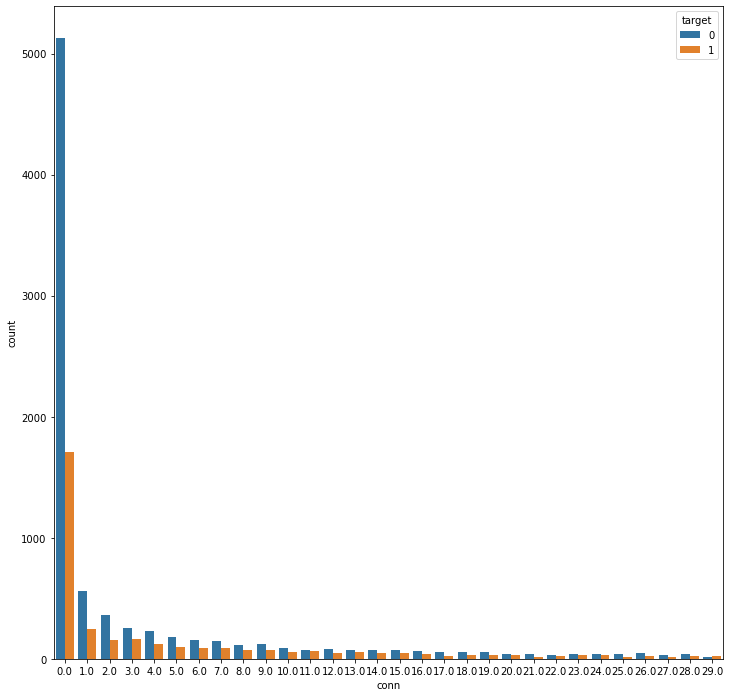

In [61]:
plt.figure(figsize=(12, 12))
sns.countplot(data=temp[temp.conn < 30], x='conn', hue='target')
plt.show()

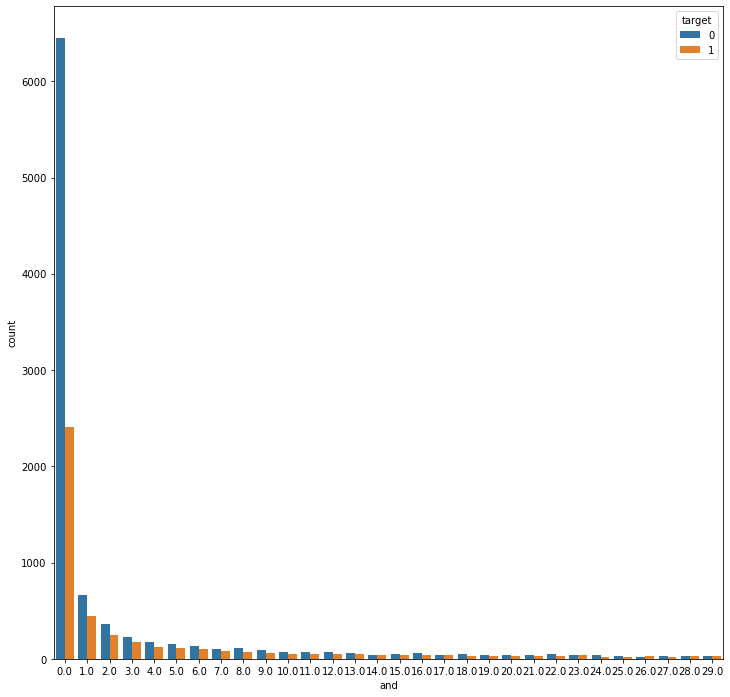

In [62]:
plt.figure(figsize=(12, 12))
sns.countplot(data=temp[temp['and'] < 30], x='and', hue='target')
plt.show()

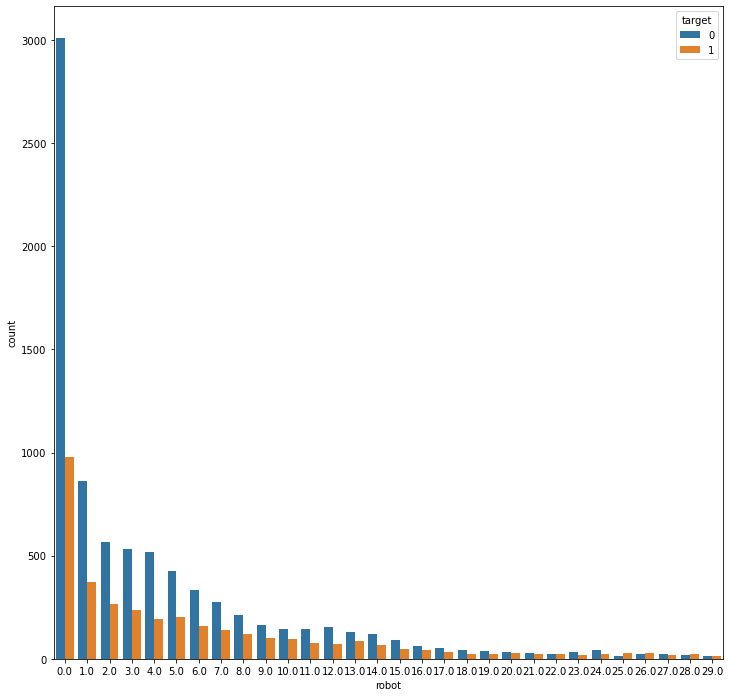

In [63]:
plt.figure(figsize=(12, 12))
sns.countplot(data=temp[temp['robot'] < 30], x='robot', hue='target')
plt.show()

## errtype 탐험하기

In [16]:
temp = train_e[['errtype', 'errcode']].drop_duplicates()

In [17]:
count = {}

for i in sorted(temp.errtype.unique()):

    print(i, "_unique: ", temp[temp.errtype == i]['errcode'].unique())
    count[i] = (len(temp[temp.errtype == i]['errcode'].unique()))

1 _unique:  ['0' 'P-44010' 'P-41011' 'P-41007 ' 'P-44010 ' 'P-41007' 'P-41011 '
 'P-41001']
2 _unique:  ['1' '0']
3 _unique:  ['1' '2' '0']
4 _unique:  ['0' '1']
5 _unique:  ['B-A8002' 'Q-64002' 'S-61001' 'U-81009' 'V-21008' '700001' 'S-64002'
 'J-30021' 'S-65002' 'Q-64001' 'H-51042' 'C-11017' 'H-51046' 'H-51049'
 'V-21002' 'V-21003' 'V-21004' 'V-21005' 'B-51042' 'M-99999' 'U-82024'
 'H-51048' '60045' 'U-82026' 'C-13053' 'C-14014' 'V-21010' 'J-20029'
 'J-30010' 'Y-00008' 'S-64000' 'En00409' 'E-59902' 'Q-73004' 'C-12032'
 'J-40011' 'U-82023' 'Q-73006' 'D-10011' 'S-65' 'M-51007' 'S-64001'
 'Y-00005' 'P_41007' '2638' 'CM a' nan '40013' 'D-99999' 'U-82004'
 'En00402' 'B-51049' 'C-11020' 'V-21007' 'M-51020' 'En00406' 'C-11087'
 'U-81000' 'Y-00004' 'C-13039' '0001' 'U-82020' 'http' 'P_41001' 'U-81014']
6 _unique:  ['1' '14']
7 _unique:  ['1' '14']
8 _unique:  ['PHONE_ERR' 'PUBLIC_ERR' '20']
9 _unique:  ['V-21002' 'V-21005' '1' 'C-14014' 'V-21008' 'C-12032' 'V-21004' 'C-13039'
 'C-11020']
10 

이걸 살펴보니 특정 에러코드가 발생한 횟수를 넣은 변수가 왜 의미가 없었는지 알겠습니다. 41번을 보면 NFANDROID2 오류 하나의 값만을 가집니다. 즉, 41번 에러타입변수는 android 랑 아예 같은 의미입니다.

실질적으로 과적합되었다고 느껴집니다. 해당 변수는 그냥 빼는 것이 맞을 것 같습니다.

아무튼 전체적으로 살펴보면 특정 몇개를 빼고는 대부분 unique_value 가 몇개 없습니다.

In [18]:
dict(sorted(count.items(), key=lambda item: item[1]))

{10: 1,
 11: 1,
 12: 1,
 13: 1,
 15: 1,
 16: 1,
 18: 1,
 19: 1,
 20: 1,
 21: 1,
 22: 1,
 24: 1,
 26: 1,
 27: 1,
 28: 1,
 35: 1,
 36: 1,
 41: 1,
 2: 2,
 4: 2,
 6: 2,
 7: 2,
 31: 2,
 37: 2,
 39: 2,
 40: 2,
 42: 2,
 3: 3,
 8: 3,
 14: 3,
 33: 3,
 17: 5,
 30: 5,
 34: 6,
 1: 8,
 23: 8,
 9: 9,
 25: 9,
 32: 55,
 5: 65,
 38: 2653}

주목해야할 에러 타입들은 아래와 같습니다. 38번, 5번, 32번, 25번, 9번, 23번, 1번, 8번, 41번.<br>
그리고 나머지는 전부 작은 숫자들 뿐입니다.



에러타입 하나씩 세세하게 살펴보겠습니다.

In [125]:
print(i, "_unique: ", temp[temp.errtype == 38]['errcode'].unique())

42 _unique:  [6796, 5738, 6467, 4893, 5507, ..., 5666, 6102, 4526, 3965, 25999]
Length: 2653
Categories (2653, object): [6796, 5738, 6467, 4893, ..., 6102, 4526, 3965, 25999]


In [141]:
train_e[train_e.errtype == 38].groupby(['model_nm', 'fwver']).count().dropna().reset_index()

,model_nm,fwver,user_id,time,errtype,errcode,year,month,day,hour,minute
0,model_0,04.22.1684,131.0,131.0,131.0,131.0,131.0,131.0,131.0,131.0,131.0
1,model_0,04.22.1750,1009.0,1009.0,1009.0,1009.0,1009.0,1009.0,1009.0,1009.0,1009.0
2,model_0,04.22.1778,291.0,291.0,291.0,291.0,291.0,291.0,291.0,291.0,291.0
3,model_0,04.22.1666,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,model_1,04.16.3553,1371.0,1371.0,1371.0,1371.0,1371.0,1371.0,1371.0,1371.0,1371.0
5,model_1,04.16.3571,77.0,77.0,77.0,77.0,77.0,77.0,77.0,77.0,77.0
6,model_1,04.16.3439,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
7,model_2,04.33.1149,32.0,32.0,32.0,32.0,32.0,32.0,32.0,32.0,32.0
8,model_2,04.33.1185,478.0,478.0,478.0,478.0,478.0,478.0,478.0,478.0,478.0
9,model_2,04.33.1261,989.0,989.0,989.0,989.0,989.0,989.0,989.0,989.0,989.0


In [156]:
train_e[train_e.errtype == 38].groupby('user_id').count().shape[0]

1822

총 1,822명이 해당 에러타입을 겪었으며, 가장 많은 유니크를 가지고 있는 38호입니다. 2600개나 됩니다.

In [126]:
print(i, "_unique: ", temp[temp.errtype == 5]['errcode'].unique())

42 _unique:  [B-A8002, Q-64002, S-61001, U-81009, V-21008, ..., 0001, U-82020, http, P_41001, U-81014]
Length: 64
Categories (64, object): [B-A8002, Q-64002, S-61001, U-81009, ..., U-82020, http, P_41001, U-81014]


In [144]:
train_e[train_e.errtype == 5].groupby(['model_nm', 'fwver']).count().dropna().reset_index()

,model_nm,fwver,user_id,time,errtype,errcode,year,month,day,hour,minute
0,model_0,04.22.1684,1321.0,1321.0,1321.0,1321.0,1321.0,1321.0,1321.0,1321.0,1321.0
1,model_0,04.22.1750,279747.0,279747.0,279747.0,279747.0,279747.0,279747.0,279747.0,279747.0,279747.0
2,model_0,04.22.1778,114488.0,114488.0,114488.0,114488.0,114488.0,114488.0,114488.0,114488.0,114488.0
3,model_0,04.22.1442,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0
4,model_0,04.22.1656,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,model_1,04.16.3553,215494.0,215494.0,215494.0,215494.0,215494.0,215494.0,215494.0,215494.0,215494.0
6,model_1,04.16.3571,5049.0,5049.0,5049.0,5049.0,5049.0,5049.0,5049.0,5049.0,5049.0
7,model_1,04.16.3569,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
8,model_2,04.33.1149,316.0,316.0,316.0,316.0,316.0,316.0,316.0,316.0,316.0
9,model_2,04.33.1185,89893.0,89893.0,89893.0,89893.0,89893.0,89893.0,89893.0,89893.0,89893.0


In [157]:
train_e[train_e.errtype == 5].groupby('user_id').count().shape[0]

11010

5번 에러는 로봇에러(로봇 이름처럼 생겨서)인데, 굉장히 많은 수가 겪었습니다. http 라는 것도 있는 걸 보니 웹과 관련이 있는 것도 같습니다.

In [127]:
print(i, "_unique: ", temp[temp.errtype == 32]['errcode'].unique())

42 _unique:  [80, 79, 81, 86, 84, ..., -270, 47, 65, 67, 66]
Length: 55
Categories (55, object): [80, 79, 81, 86, ..., 47, 65, 67, 66]


In [145]:
train_e[train_e.errtype == 32].groupby(['model_nm', 'fwver']).count().dropna().reset_index()

,model_nm,fwver,user_id,time,errtype,errcode,year,month,day,hour,minute
0,model_0,04.22.1750,3104.0,3104.0,3104.0,3104.0,3104.0,3104.0,3104.0,3104.0,3104.0
1,model_0,04.22.1778,1298.0,1298.0,1298.0,1298.0,1298.0,1298.0,1298.0,1298.0,1298.0
2,model_1,04.16.3553,1073268.0,1073268.0,1073268.0,1073268.0,1073268.0,1073268.0,1073268.0,1073268.0,1073268.0
3,model_1,04.16.3571,37367.0,37367.0,37367.0,37367.0,37367.0,37367.0,37367.0,37367.0,37367.0
4,model_1,04.16.3569,199.0,199.0,199.0,199.0,199.0,199.0,199.0,199.0,199.0
5,model_2,04.33.1185,4078.0,4078.0,4078.0,4078.0,4078.0,4078.0,4078.0,4078.0,4078.0
6,model_2,04.33.1261,8961.0,8961.0,8961.0,8961.0,8961.0,8961.0,8961.0,8961.0,8961.0
7,model_5,04.82.1684,232.0,232.0,232.0,232.0,232.0,232.0,232.0,232.0,232.0
8,model_5,04.82.1778,86.0,86.0,86.0,86.0,86.0,86.0,86.0,86.0,86.0
9,model_7,05.66.3571,1347.0,1347.0,1347.0,1347.0,1347.0,1347.0,1347.0,1347.0,1347.0


In [158]:
train_e[train_e.errtype == 32].groupby('user_id').count().shape[0]

1933

약 2천명이 겪었습니다. 55개의 유니크를 가진 32호입니다.

In [128]:
print(i, "_unique: ", temp[temp.errtype == 25]['errcode'].unique())

42 _unique:  [2, scanning timeout, 1, UNKNOWN, terminate by peer user, connectionterminated by local host, connection timeout, connection fail to establish, L2CAP connection cancelled]
Categories (9, object): [2, scanning timeout, 1, UNKNOWN, ..., connectionterminated by local host, connection timeout, connection fail to establish, L2CAP connection cancelled]


In [146]:
train_e[train_e.errtype == 25].groupby(['model_nm', 'fwver']).count().dropna().reset_index()

,model_nm,fwver,user_id,time,errtype,errcode,year,month,day,hour,minute
0,model_0,04.22.1684,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,model_0,04.22.1750,439.0,439.0,439.0,439.0,439.0,439.0,439.0,439.0,439.0
2,model_0,04.22.1778,204.0,204.0,204.0,204.0,204.0,204.0,204.0,204.0,204.0
3,model_0,04.22.1442,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,model_1,04.16.3553,171.0,171.0,171.0,171.0,171.0,171.0,171.0,171.0,171.0
5,model_1,04.16.3571,52.0,52.0,52.0,52.0,52.0,52.0,52.0,52.0,52.0
6,model_2,04.33.1185,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0
7,model_2,04.33.1261,249.0,249.0,249.0,249.0,249.0,249.0,249.0,249.0,249.0
8,model_7,05.66.3237,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0
9,model_8,04.73.2237,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [159]:
train_e[train_e.errtype == 25].groupby('user_id').count().shape[0]

420

굉장히 적은 수가 겪었습니다. 근데 이상하게도 겪은 사람이 많지가 않네요.

In [129]:
print(i, "_unique: ", temp[temp.errtype == 9]['errcode'].unique())

42 _unique:  [V-21002, V-21005, 1, C-14014, V-21008, C-12032, V-21004, C-13039, C-11020]
Categories (9, object): [V-21002, V-21005, 1, C-14014, ..., C-12032, V-21004, C-13039, C-11020]


In [147]:
train_e[train_e.errtype == 9].groupby(['model_nm', 'fwver']).count().dropna().reset_index()

,model_nm,fwver,user_id,time,errtype,errcode,year,month,day,hour,minute
0,model_0,04.22.1750,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0
1,model_0,04.22.1778,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0
2,model_1,04.16.3553,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0
3,model_2,04.33.1185,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0
4,model_2,04.33.1261,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0
5,model_3,05.15.2138,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
6,model_4,03.11.1167,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [160]:
train_e[train_e.errtype == 9].groupby('user_id').count().shape[0]

63

더더더 적게 겪은 5자리 VC형 로봇에러. 고작 63명만이 이 에러를 겪었습니다.

In [130]:
print(i, "_unique: ", temp[temp.errtype == 23]['errcode'].unique())

42 _unique:  [standby, active, connection timeout, terminate by peer user, connection fail to establish, connectionterminated by local host, UNKNOWN, connection fail for LMP response timout]
Categories (8, object): [standby, active, connection timeout, terminate by peer user, connection fail to establish, connectionterminated by local host, UNKNOWN, connection fail for LMP response timout]


In [148]:
train_e[train_e.errtype == 23].groupby(['model_nm', 'fwver']).count().dropna().reset_index()

,model_nm,fwver,user_id,time,errtype,errcode,year,month,day,hour,minute
0,model_0,04.22.1684,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0
1,model_0,04.22.1750,406403.0,406403.0,406403.0,406403.0,406403.0,406403.0,406403.0,406403.0,406403.0
2,model_0,04.22.1778,167060.0,167060.0,167060.0,167060.0,167060.0,167060.0,167060.0,167060.0,167060.0
3,model_0,04.22.1442,696.0,696.0,696.0,696.0,696.0,696.0,696.0,696.0,696.0
4,model_0,04.22.1656,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
5,model_1,04.16.3553,1468296.0,1468296.0,1468296.0,1468296.0,1468296.0,1468296.0,1468296.0,1468296.0,1468296.0
6,model_1,04.16.3571,22251.0,22251.0,22251.0,22251.0,22251.0,22251.0,22251.0,22251.0,22251.0
7,model_1,04.16.3439,37.0,37.0,37.0,37.0,37.0,37.0,37.0,37.0,37.0
8,model_1,04.16.3569,324.0,324.0,324.0,324.0,324.0,324.0,324.0,324.0,324.0
9,model_1,04.16.2641,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0


In [161]:
train_e[train_e.errtype == 23].groupby('user_id').count().shape[0]

10046

1만명이 겪었습니다. 꽤나 많은 숫자입니다. 25호랑 많이 비슷한 에러타입입니다.

In [131]:
print(i, "_unique: ", temp[temp.errtype == 1]['errcode'].unique())

42 _unique:  [0, P-44010, P-41011, P-41007, P-44010, P-41007, P-41011, P-41001]
Categories (8, object): [0, P-44010, P-41011, P-41007, P-44010, P-41007, P-41011, P-41001]


In [149]:
train_e[train_e.errtype == 1].groupby(['model_nm', 'fwver']).count().dropna().reset_index()

,model_nm,fwver,user_id,time,errtype,errcode,year,month,day,hour,minute
0,model_0,04.22.1684,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,model_0,04.22.1750,83.0,83.0,83.0,83.0,83.0,83.0,83.0,83.0,83.0
2,model_0,04.22.1778,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0
3,model_1,04.16.3553,69.0,69.0,69.0,69.0,69.0,69.0,69.0,69.0,69.0
4,model_2,04.33.1149,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,model_2,04.33.1185,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0
6,model_2,04.33.1261,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0,66.0
7,model_3,05.15.2138,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0
8,model_4,03.11.1149,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0
9,model_4,03.11.1167,20989.0,20989.0,20989.0,20989.0,20989.0,20989.0,20989.0,20989.0,20989.0


In [162]:
train_e[train_e.errtype == 1].groupby('user_id').count().shape[0]

950

P-로봇 에러입니다. 로봇형 에러가 또 있네요

In [136]:
print(i, "_unique: ", temp[temp.errtype == 8]['errcode'].unique())

42 _unique:  [PHONE_ERR, PUBLIC_ERR, 20]
Categories (3, object): [PHONE_ERR, PUBLIC_ERR, 20]


In [150]:
train_e[train_e.errtype == 8].groupby(['model_nm', 'fwver']).count().dropna().reset_index()

,model_nm,fwver,user_id,time,errtype,errcode,year,month,day,hour,minute
0,model_0,04.22.1750,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0
1,model_0,04.22.1778,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0
2,model_1,04.16.3553,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
3,model_2,04.33.1185,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0
4,model_2,04.33.1261,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0
5,model_3,05.15.2138,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0
6,model_4,03.11.1167,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0
7,model_7,05.66.3237,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [163]:
train_e[train_e.errtype == 8].groupby('user_id').count().shape[0]

64

64명이라니 최저인가요? phone, public err입니다.

In [135]:
print(i, "_unique: ", temp[temp.errtype == 41]['errcode'].unique())

42 _unique:  [NFANDROID2]
Categories (1, object): [NFANDROID2]


In [151]:
train_e[train_e.errtype == 41].groupby(['model_nm', 'fwver']).count().dropna().reset_index()

,model_nm,fwver,user_id,time,errtype,errcode,year,month,day,hour,minute
0,model_0,04.22.1684,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0
1,model_0,04.22.1750,23316.0,23316.0,23316.0,23316.0,23316.0,23316.0,23316.0,23316.0,23316.0
2,model_0,04.22.1778,11942.0,11942.0,11942.0,11942.0,11942.0,11942.0,11942.0,11942.0,11942.0
3,model_1,04.16.3553,13965.0,13965.0,13965.0,13965.0,13965.0,13965.0,13965.0,13965.0,13965.0
4,model_1,04.16.3571,481.0,481.0,481.0,481.0,481.0,481.0,481.0,481.0,481.0
5,model_2,04.33.1149,95.0,95.0,95.0,95.0,95.0,95.0,95.0,95.0,95.0
6,model_2,04.33.1171,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,model_2,04.33.1185,14724.0,14724.0,14724.0,14724.0,14724.0,14724.0,14724.0,14724.0,14724.0
8,model_2,04.33.1261,39266.0,39266.0,39266.0,39266.0,39266.0,39266.0,39266.0,39266.0,39266.0
9,model_5,04.82.1684,220.0,220.0,220.0,220.0,220.0,220.0,220.0,220.0,220.0


In [164]:
train_e[train_e.errtype == 41].groupby('user_id').count().shape[0]

6142

6천명이 겪은 안드로이드 에러

각 에러당 몇명이나 겪었을지를 살펴보지 않았었네요.

In [56]:
err_type_user_counts = []
for i in sorted(train_e.errtype.unique()):
    print(i, "_'s Unique User Counts: ", train_e[train_e.errtype == i].groupby('user_id').count().shape[0])
    err_type_user_counts.append(train_e[train_e.errtype == i].groupby('user_id').count().shape[0])

1 _'s Unique User Counts:  950
2 _'s Unique User Counts:  390
3 _'s Unique User Counts:  1679
4 _'s Unique User Counts:  6881
5 _'s Unique User Counts:  11010
6 _'s Unique User Counts:  6467
7 _'s Unique User Counts:  7648
8 _'s Unique User Counts:  64
9 _'s Unique User Counts:  63
10 _'s Unique User Counts:  2360
11 _'s Unique User Counts:  14767
12 _'s Unique User Counts:  14799
13 _'s Unique User Counts:  3711
14 _'s Unique User Counts:  7891
15 _'s Unique User Counts:  14545
16 _'s Unique User Counts:  14431
17 _'s Unique User Counts:  5747
18 _'s Unique User Counts:  1768
19 _'s Unique User Counts:  419
20 _'s Unique User Counts:  1546
21 _'s Unique User Counts:  381
22 _'s Unique User Counts:  10281
23 _'s Unique User Counts:  10046
24 _'s Unique User Counts:  2519
25 _'s Unique User Counts:  420
26 _'s Unique User Counts:  13026
27 _'s Unique User Counts:  2267
28 _'s Unique User Counts:  2275
30 _'s Unique User Counts:  375
31 _'s Unique User Counts:  11091
32 _'s Unique User C

에러로그에 뜬 전체 유저를 대상으로 했지만, 실제 p유저들을 대상으로는 몇 명이나 떴을지 살펴보아야겠습니다.

In [52]:
train_p['target'] = 1

In [53]:
temp = pd.merge(train_e, train_p, how='left', on=['user_id'])

In [54]:
temp2 = temp[temp.target == 1]

In [55]:
err_type_user_counts_origin = []
for i in sorted(temp2.errtype.unique()):
    print(i, "_'s Unique User Counts: ", temp2[temp2.errtype == i].groupby('user_id').count().shape[0])
    err_type_user_counts_origin.append(temp2[temp2.errtype == i].groupby('user_id').count().shape[0])

1 _'s Unique User Counts:  242
2 _'s Unique User Counts:  168
3 _'s Unique User Counts:  465
4 _'s Unique User Counts:  2298
5 _'s Unique User Counts:  4028
6 _'s Unique User Counts:  2662
7 _'s Unique User Counts:  3093
8 _'s Unique User Counts:  13
9 _'s Unique User Counts:  38
10 _'s Unique User Counts:  1134
11 _'s Unique User Counts:  4971
12 _'s Unique User Counts:  4974
13 _'s Unique User Counts:  1667
14 _'s Unique User Counts:  3224
15 _'s Unique User Counts:  4978
16 _'s Unique User Counts:  4977
17 _'s Unique User Counts:  2498
18 _'s Unique User Counts:  1521
19 _'s Unique User Counts:  346
20 _'s Unique User Counts:  1333
21 _'s Unique User Counts:  316
22 _'s Unique User Counts:  3975
23 _'s Unique User Counts:  3920
24 _'s Unique User Counts:  1166
25 _'s Unique User Counts:  360
26 _'s Unique User Counts:  4632
27 _'s Unique User Counts:  958
28 _'s Unique User Counts:  959
30 _'s Unique User Counts:  260
31 _'s Unique User Counts:  4153
32 _'s Unique User Counts:  927


In [57]:
etuc_1 = np.array(err_type_user_counts)
etuc_2 = np.array(err_type_user_counts_origin)

In [58]:
etuc_1

array([  950,   390,  1679,  6881, 11010,  6467,  7648,    64,    63,
        2360, 14767, 14799,  3711,  7891, 14545, 14431,  5747,  1768,
         419,  1546,   381, 10281, 10046,  2519,   420, 13026,  2267,
        2275,   375, 11091,  1933, 11074,  3733,  2039,  8435,  8434,
        1822,   766, 10462,  6142,  6382])

In [59]:
etuc_2

array([ 242,  168,  465, 2298, 4028, 2662, 3093,   13,   38, 1134, 4971,
       4974, 1667, 3224, 4978, 4977, 2498, 1521,  346, 1333,  316, 3975,
       3920, 1166,  360, 4632,  958,  959,  260, 4153,  927, 4138, 1963,
       1186, 3262, 3259,  927,  405, 4052, 2596, 2490])

In [60]:
etuc_1 - etuc_2

array([ 708,  222, 1214, 4583, 6982, 3805, 4555,   51,   25, 1226, 9796,
       9825, 2044, 4667, 9567, 9454, 3249,  247,   73,  213,   65, 6306,
       6126, 1353,   60, 8394, 1309, 1316,  115, 6938, 1006, 6936, 1770,
        853, 5173, 5175,  895,  361, 6410, 3546, 3892])

In [61]:
((etuc_2 / etuc_1) * 100).round(2)

array([25.47, 43.08, 27.7 , 33.4 , 36.58, 41.16, 40.44, 20.31, 60.32,
       48.05, 33.66, 33.61, 44.92, 40.86, 34.22, 34.49, 43.47, 86.03,
       82.58, 86.22, 82.94, 38.66, 39.02, 46.29, 85.71, 35.56, 42.26,
       42.15, 69.33, 37.44, 47.96, 37.37, 52.59, 58.17, 38.67, 38.64,
       50.88, 52.87, 38.73, 42.27, 39.02])

In [62]:
temp = pd.DataFrame()
temp['etuc_1'] = etuc_1
temp['etuc_2'] = etuc_2
temp['div'] = ((etuc_2 / etuc_1) * 100).round(2)

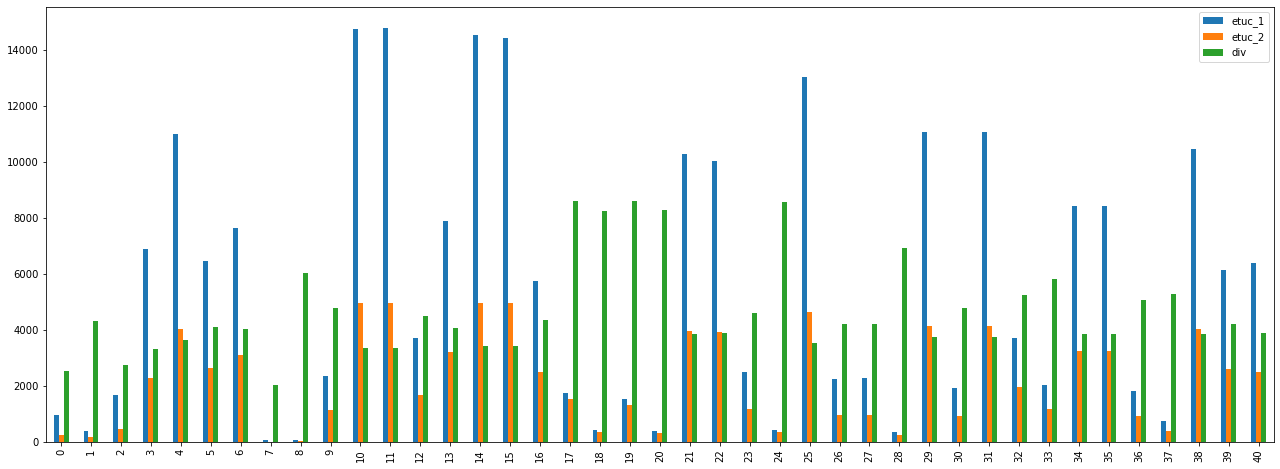

In [248]:
temp.plot(kind='bar', figsize=(22, 8))
plt.show()

에러 발생 유저 중에 실제 신고로 이어진 에러 타입이 나뉩니다.

In [216]:
np.arange(1, 43, 1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42])

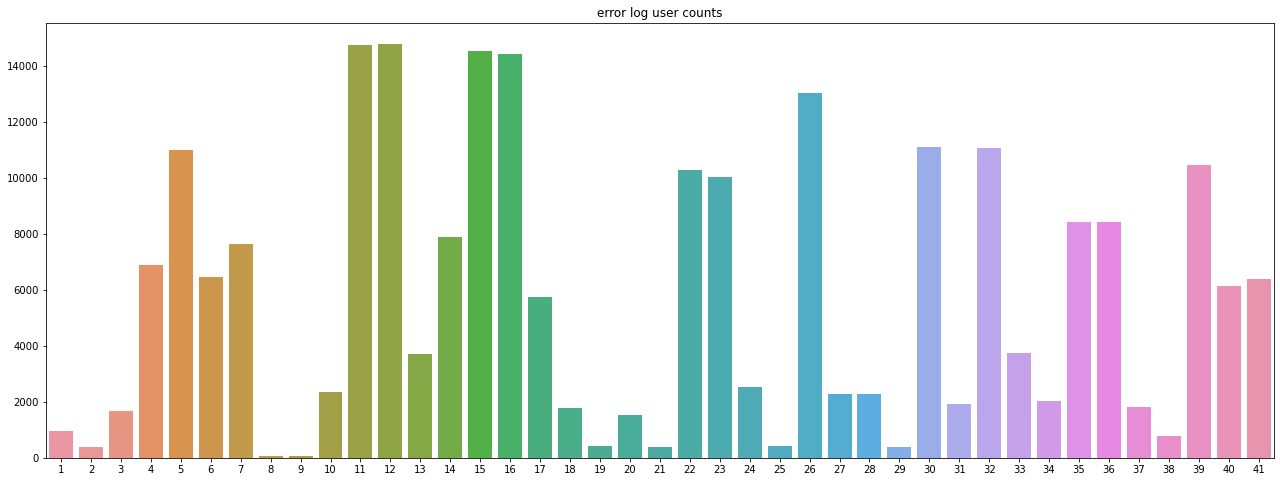

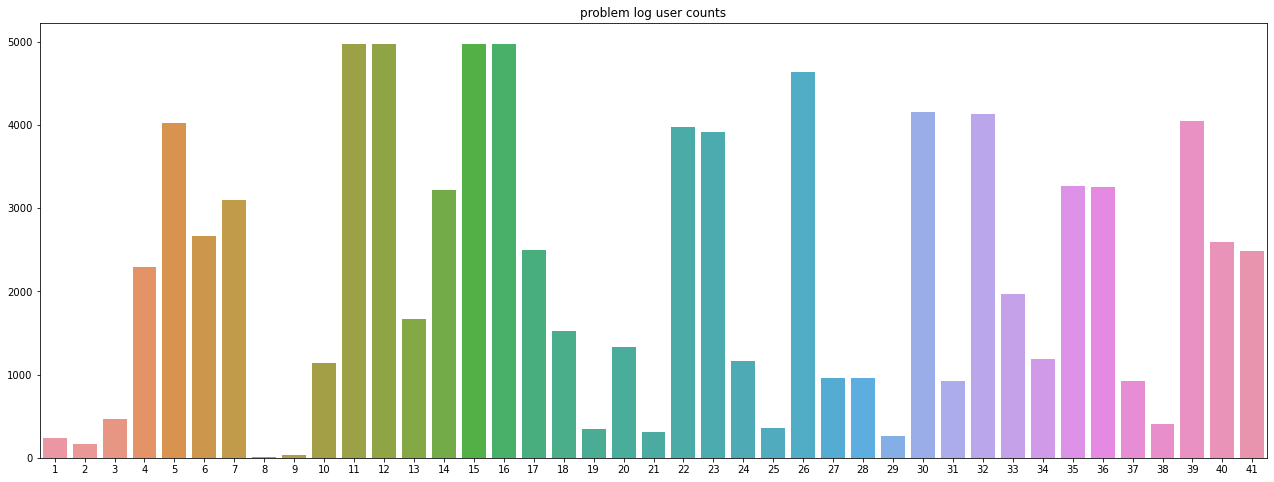

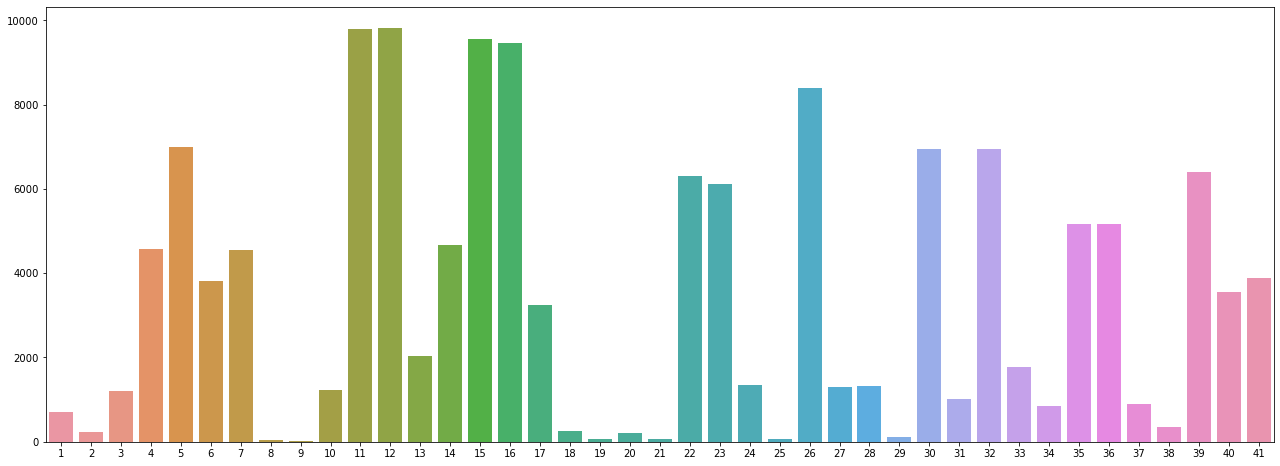

In [225]:
plt.figure(figsize=(22, 8))
sns.barplot(np.arange(1, 42, 1), etuc_1)
plt.title('error log user counts')
plt.show()
plt.figure(figsize=(22, 8))
sns.barplot(np.arange(1, 42, 1), etuc_2)
plt.title('problem log user counts')
plt.show()
plt.figure(figsize=(22, 8))
sns.barplot(np.arange(1, 42, 1), etuc_1 - etuc_2)
plt.show()

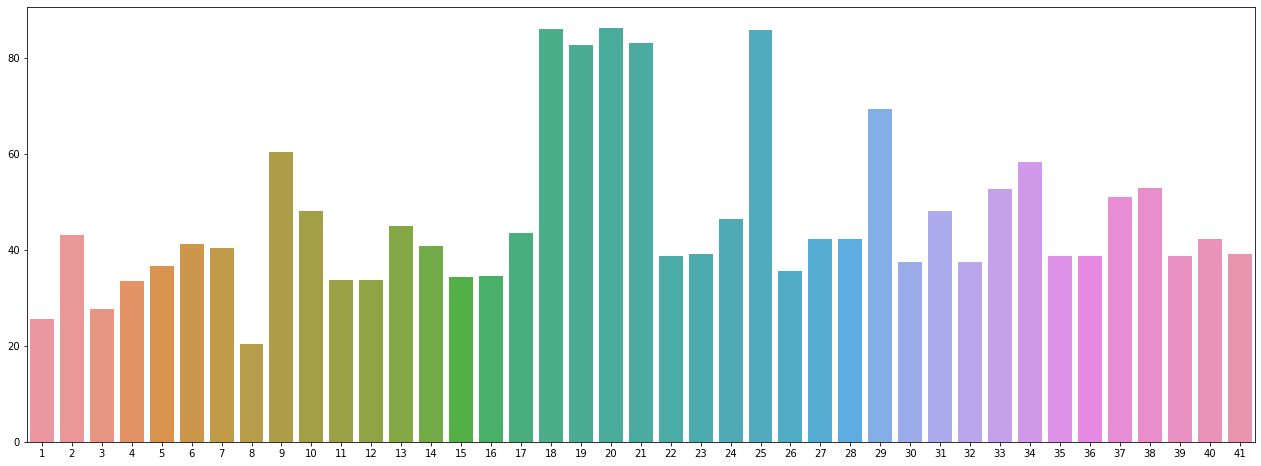

In [220]:
plt.figure(figsize=(22, 8))
sns.barplot(np.arange(1, 42, 1), ((etuc_2 / etuc_1) * 100).round(2))
plt.show()

29호가 없기 때문에, 29호부터는 한개씩 넘어갑니다.

18, 19, 20, 21, 25 호가 상당히 높은 비율로 신고로 이어졌습니다.<br>
그 다음으로는 30호, 9호, 35호 등이 있습니다.

낮은 신고율을 보이는 에러타입은 먼저 8호. 8호는 카운트도 적습니다. 다음으로 1호. 그 외에는 다들 비슷한 수준입니다.

특이했던 에러타입들 : 38호, 5호, 32호, 25호, 9호, 23호, 1호, 8호, 41호.

매우 높은 특이 에러타입들: 25호, 9호

매우 낮은 특이 에러타입들: 1호, 8호

매우 높지도, 낮지도 않은 특이한 에러타입들: 38호, 5호, 32호, 23호, 41호

애매한 친구들이야말로 세부 에러 코드에 따라 다른 경향을 보이지 않을까도 합니다.

In [252]:
temp.set_index([sorted(train_e.errtype.unique())])

,etuc_1,etuc_2,div
1,950,242,25.47
2,390,168,43.08
3,1679,465,27.70
4,6881,2298,33.40
5,11010,4028,36.58
6,6467,2662,41.16
7,7648,3093,40.44
8,64,13,20.31
9,63,38,60.32
10,2360,1134,48.05


모수가 큰 23호와 5호를 살펴봅시다.

In [254]:
train_e[train_e.errtype == 23]['errcode'].unique()

[standby, active, connection timeout, terminate by peer user, connection fail to establish, connectionterminated by local host, UNKNOWN, connection fail for LMP response timout]
Categories (8, object): [standby, active, connection timeout, terminate by peer user, connection fail to establish, connectionterminated by local host, UNKNOWN, connection fail for LMP response timout]

In [278]:
temp_23th = temp2[temp2.errtype == 23][['errcode', 'user_id']]

In [279]:
temp_23th_drop = temp_23th.drop_duplicates()

In [289]:
temp_23th_drop.errcode.value_counts().head(10)

connection timeout                         3231
standby                                    2928
active                                     2663
connection fail to establish               1344
terminate by peer user                      911
connectionterminated by local host          853
UNKNOWN                                     441
connection fail for LMP response timout      71
6102                                          0
8549                                          0
Name: errcode, dtype: int64

In [286]:
train_23th = train_e[train_e.errtype == 23][['errcode', 'user_id']]

In [287]:
train_23th_drop = train_23th.drop_duplicates()

In [290]:
train_23th_drop.errcode.value_counts().head(10)

connection timeout                         7990
standby                                    7385
active                                     6314
connection fail to establish               2760
connectionterminated by local host         1720
terminate by peer user                     1225
UNKNOWN                                     872
connection fail for LMP response timout     114
6102                                          0
8549                                          0
Name: errcode, dtype: int64

그냥 대체로 전부 절반정도 신고한거 같은데...

In [291]:
temp_5th = temp2[temp2.errtype == 5][['errcode', 'user_id']]

In [292]:
temp_5th_drop = temp_5th.drop_duplicates()

In [293]:
temp_5th_drop.errcode.value_counts().head(10)

B-A8002    2470
S-61001    1868
Q-64002     677
S-65002     257
V-21008     171
700001      170
H-51042     159
H-51046      63
S-64002      48
C-11017      40
Name: errcode, dtype: int64

In [297]:
train_5th = train_e[train_e.errtype == 5][['errcode', 'user_id']]

train_5th_drop = train_5th.drop_duplicates()

train_5th_drop.errcode.value_counts().head(10)

B-A8002    5860
S-61001    4085
Q-64002    2832
S-65002     735
H-51042     366
700001      352
V-21008     349
H-51046     109
C-11017     101
S-64002      93
Name: errcode, dtype: int64

얘도 얼추 비슷한거 같은데...

In [298]:
temp_25th = temp2[temp2.errtype == 25][['errcode', 'user_id']]
temp_25th_drop = temp_25th.drop_duplicates()
temp_25th_drop.errcode.value_counts().head(10)

1                                     114
scanning timeout                       94
2                                      77
UNKNOWN                                71
connectionterminated by local host     58
connection timeout                     16
terminate by peer user                  9
L2CAP connection cancelled              4
connection fail to establish            1
6102                                    0
Name: errcode, dtype: int64

In [299]:
train_25th = train_e[train_e.errtype == 25][['errcode', 'user_id']]
train_25th_drop = train_25th.drop_duplicates()
train_25th_drop.errcode.value_counts().head(10)

1                                     132
scanning timeout                      116
2                                      87
UNKNOWN                                84
connectionterminated by local host     64
connection timeout                     18
terminate by peer user                  9
L2CAP connection cancelled              5
connection fail to establish            1
6102                                    0
Name: errcode, dtype: int64

거의 모든 유저들이 겪은 11, 12, 15, 16을 봐봅시다.

In [300]:
temp_11th = temp2[temp2.errtype == 11][['errcode', 'user_id']]
temp_11th_drop = temp_11th.drop_duplicates()
temp_11th_drop.errcode.value_counts().head(10)

1       4971
6102       0
4290       0
7686       0
6743       0
6447       0
6212       0
5658       0
5541       0
5430       0
Name: errcode, dtype: int64

In [301]:
train_11th = train_e[train_e.errtype == 11][['errcode', 'user_id']]
train_11th_drop = train_11th.drop_duplicates()
train_11th_drop.errcode.value_counts().head(10)

1       14767
6102        0
4290        0
7686        0
6743        0
6447        0
6212        0
5658        0
5541        0
5430        0
Name: errcode, dtype: int64

In [63]:
temp9 = pd.DataFrame()
temp9['etuc_1'] = etuc_1
temp9['etuc_2'] = etuc_2
temp9['div'] = ((etuc_2 / etuc_1) * 100).round(2)

In [68]:
temp9['unique'] = count.values()

In [201]:
temp9 = temp9.set_index(pd.Index(sorted(train_e.errtype.unique())))

In [260]:
temp9[temp9.unique == 2]

,etuc_1,etuc_2,div,unique
2,390,168,43.08,2
4,6881,2298,33.40,2
6,6467,2662,41.16,2
7,7648,3093,40.44,2
31,11091,4153,37.44,2
37,8434,3259,38.64,2
39,766,405,52.87,2
40,10462,4052,38.73,2
42,6382,2490,39.02,2


In [203]:
temp9[temp9.unique == 3]

,etuc_1,etuc_2,div,unique
3,1679,465,27.70,3
8,64,13,20.31,3
14,7891,3224,40.86,3
33,11074,4138,37.37,3


In [204]:
temp9[temp9.unique == 5]

,etuc_1,etuc_2,div,unique
17,5747,2498,43.47,5
30,375,260,69.33,5


In [263]:
temp9[temp9.unique == 6]

,etuc_1,etuc_2,div,unique
34,3733,1963,52.59,6


In [205]:
temp9[temp9.unique == 8]

,etuc_1,etuc_2,div,unique
1,950,242,25.47,8
23,10046,3920,39.02,8


In [206]:
temp9.sort_values('unique')[temp9.unique >= 9]

,etuc_1,etuc_2,div,unique
9,63,38,60.32,9
25,420,360,85.71,9
32,1933,927,47.96,55
5,11010,4028,36.58,65
38,1822,927,50.88,2653


나머지는 변수가 너무 많아집니다. 기각

단일 값인 에러타입들: 10, 11, 12, 13, 15, 16, 18, 19, 20, 21, 22, 24, 26, 27, 28, 35, 36, 41

모수가 너무 적어서(2천개 이하) 테스트 하지 않은 에러타입들: 1, 2, 3, 8, 9, 25, 39, 30 

값이 너무 많아서(10개 이상) 테스트 하지 않은 에러타입들: 5, 32, 38

성능이 좋지 않았던 에러타입들: 7, 14, 17, 31, 37, 40, 42

성능을 올려 준 에러타입들: 23, 33

In [252]:
used = [ 10, 11, 12, 13, 15, 16, 18, 19, 20, 21, 22, 24, 26, 27, 28, 35, 36, 41, 1, 2, 3, 8, 9, 25, 39, 30, 5, 32, 38, 7, 14, 17, 31, 37, 40, 42, 23, 33]

In [258]:
set(train_e.errtype.unique()).difference(used)

{4, 6, 34}

가설 대로라면 5번을 건드려야 하는데

In [293]:
train_e[train_e.errtype == 5].errcode.unique()

array(['B-A8002', 'Q-64002', 'S-61001', 'U-81009', 'V-21008', '700001',
       'S-64002', 'J-30021', 'S-65002', 'Q-64001', 'H-51042', 'C-11017',
       'H-51046', 'H-51049', 'V-21002', 'V-21003', 'V-21004', 'V-21005',
       'B-51042', 'M-99999', 'U-82024', 'H-51048', '60045', 'U-82026',
       'C-13053', 'C-14014', 'V-21010', 'J-20029', 'J-30010', 'Y-00008',
       'S-64000', 'En00409', 'E-59902', 'Q-73004', 'C-12032', 'J-40011',
       'U-82023', 'Q-73006', 'D-10011', 'S-65', 'M-51007', 'S-64001',
       'Y-00005', 'P_41007', '2638', 'CM a', nan, '40013', 'D-99999',
       'U-82004', 'En00402', 'B-51049', 'C-11020', 'V-21007', 'M-51020',
       'En00406', 'C-11087', 'U-81000', 'Y-00004', 'C-13039', '0001',
       'U-82020', 'http', 'P_41001', 'U-81014'], dtype=object)

In [289]:
train_e[train_e.errtype == 5].errcode.nunique()

64

다행히도 패턴이 있습니다. 번호로 되어 있는 몇개와, http, CM a, 그리고 nan값. 나머지는 알파벳과 숫자의 조합인데, 앞의 대문자로만 뭉쳐주면 안될까요?

In [306]:
temp5 = train_e[train_e.errtype == 5]

In [320]:
temp5re = train_e[train_e.errtype == 5]

In [307]:
temp5.errcode = temp5.errcode.apply(lambda x: str(x)[:2])

In [308]:
temp5.errcode.unique(), temp5.errcode.nunique()

(array(['B-', 'Q-', 'S-', 'U-', 'V-', '70', 'J-', 'H-', 'C-', 'M-', '60',
        'Y-', 'En', 'E-', 'D-', 'P_', '26', 'CM', 'na', '40', '00', 'ht'],
       dtype=object),
 22)

22개로 줄었네요

In [319]:
temp5[['user_id', 'errcode', 'hour']].groupby(['user_id', 'errcode']).count().unstack().count()

      errcode
hour  00            2
      26            1
      40            1
      60            9
      70          352
      B-         5864
      C-          149
      CM            1
      D-            2
      E-            4
      En            6
      H-          521
      J-           40
      M-           59
      P_            2
      Q-         2835
      S-         4706
      U-           52
      V-          410
      Y-           25
      ht            1
      na            1
dtype: int64

아니 근데, 실질적으로 변별력을 가지는 에러코드들은 B-, Q-, S- 등 뿐입니다.

In [321]:
temp5re[['user_id', 'errcode', 'hour']].groupby(['user_id', 'errcode']).count().unstack().count()

      errcode
hour  0001          2
      2638          1
      40013         1
      60045         9
      700001      352
      B-51042      53
      B-51049       3
      B-A8002    5860
      C-11017     101
      C-11020       2
      C-11087       1
      C-12032       8
      C-13039       1
      C-13053      34
      C-14014       6
      CM a          1
      D-10011       1
      D-99999       1
      E-59902       4
      En00402       3
      En00406       1
      En00409       3
      H-51042     366
      H-51046     109
      H-51048       8
      H-51049      45
      J-20029       2
      J-30010       5
      J-30021      32
      J-40011       6
      M-51007       3
      M-51020       3
      M-99999      53
      P_41001       1
      P_41007       1
      Q-64001      72
      Q-64002    2832
      Q-73004      18
      Q-73006       5
      S-61001    4085
      S-64000       2
      S-64001       2
      S-64002      93
      S-65          1
      S-65002     

쓸만한 애들 3개 정도만 넣어주면 될 거 같은데... 나머지는 그냥 기타로 넣고...

## 변수 만들어 주기

### 2차-유저별로 가장 많이 발생한 errtype은 무엇인가?

In [35]:
train_e.groupby(['user_id', 'errtype']).count().reset_index()

,user_id,errtype,time,model_nm,fwver,errcode,year,month,day,hour,minute
0,10000,3,8,8,8,8,8,8,8,8,8
1,10000,4,104,104,104,104,104,104,104,104,104
2,10000,6,1,1,1,1,1,1,1,1,1
3,10000,7,1,1,1,1,1,1,1,1,1
4,10000,10,7,7,7,7,7,7,7,7,7
...,...,...,...,...,...,...,...,...,...,...,...
231034,24999,13,4,4,4,4,4,4,4,4,4
231035,24999,14,20,20,20,20,20,20,20,20,20
231036,24999,15,135,135,135,135,135,135,135,135,135
231037,24999,16,135,135,135,135,135,135,135,135,135


In [36]:
train_e.groupby(['user_id', 'errtype']).count().max(level=0)

,time,model_nm,fwver,errcode,year,month,day,hour,minute
user_id,,,,,,,,,
10000,104,104,104,104,104,104,104,104,104
10001,756,756,756,756,756,756,756,756,756
10002,132,132,132,132,132,132,132,132,132
10003,65,65,65,65,65,65,65,65,65
10004,176,176,176,176,176,176,176,176,176
...,...,...,...,...,...,...,...,...,...
24995,31,31,31,31,31,31,31,31,31
24996,1,1,1,1,1,1,1,1,1
24997,223,223,223,223,223,223,223,223,223


### 2차-유저별로 몇개의 모델을 썼는가?

In [20]:
temp = train_e[['user_id', 'model_nm']]

In [21]:
temp = temp.drop_duplicates()

In [22]:
train_model_count = temp.groupby('user_id').count()

In [23]:
test_model_count = test_e[['user_id', 'model_nm']].drop_duplicates().groupby('user_id').count()

In [24]:
train_model_count.tail()

,model_nm
user_id,
24995,1
24996,1
24997,1
24998,1
24999,1


### 2차-유저별로 몇개의 fw를 썼는가?

In [25]:
train_fwver_count = train_e[['user_id', 'fwver']].drop_duplicates().groupby('user_id').count()
test_fwver_count = test_e[['user_id', 'fwver']].drop_duplicates().groupby('user_id').count()

In [26]:
train_fwver_count.head()

,fwver
user_id,
10000,1
10001,2
10002,1
10003,2
10004,2


### 2차-유저별로 몇개의 err가 떴는가?

유저 당 err가 몇 번이나 떴는가에 대한 단순 집계입니다. 시리즈로 뽑겠습니다.

In [27]:
train_err_count = train_e.groupby('user_id')['errcode'].count()
test_err_count = test_e.groupby('user_id')['errcode'].count()

In [28]:
train_err_count

user_id
10000     317
10001    2365
10002     306
10003     306
10004     777
         ... 
24995     194
24996       4
24997     826
24998     155
24999     570
Name: errcode, Length: 15000, dtype: int64

In [29]:
test_err_count

user_id
30000     2750
30001      284
30002      941
30003      371
30004      881
         ...  
44994     1115
44995      515
44996     2233
44997    24671
44998      873
Name: errcode, Length: 14998, dtype: int64

### 3차-유저별로 특정 에러를 얼마나 겪었는가?

#### 유저별로 'conn' 관련한 에러를 얼마나 겪었는가?

In [30]:
#train_error_conn = train_e[train_e.errcode.str.contains('conn')].groupby('user_id').count()['errcode']
#test_error_conn = test_e[test_e.errcode.str.contains('conn')].groupby('user_id').count()['errcode']

#### 유저별로 C-11012 유형의 에러를 얼마나 겪었는가?

In [31]:
#train_error_robot = train_e[train_e.errcode.str.contains('-')].groupby('user_id').count()['errcode']
#test_error_robot = test_e[test_e.errcode.str.contains('-')].groupby('user_id').count()['errcode']

#### 유저별로 ANDROID 유형의 에러를 얼마나 겪었는가?

In [32]:
# train_error_android = train_e[train_e.errcode.str.contains('ANDROID')].groupby('user_id').count()['errcode']
# test_error_android = test_e[test_e.errcode.str.contains('ANDROID')].groupby('user_id').count()['errcode']

세개를 합쳐주겠습니다. 컬럼명이 겹치기 때문이죠.

In [33]:
#train_specific_error = pd.concat([train_error_conn, train_error_robot, train_error_android], axis=1).fillna(0)
#train_specific_error.columns = ['err_conn', 'err_robot', 'err_and']

In [34]:
# test_specific_error = pd.concat([test_error_conn, test_error_robot, test_error_android], axis=1).fillna(0)
# test_specific_error.columns = ['err_conn', 'err_robot', 'err_and']

### 5차-유저별로 특정 에러를 겪었는가? yes or no

conn, robot, and 에러들을 사용자가 겪은 갯수로 변수를 넣어주었는데, 이번에는 {0, 1}로 발생 여부만 넣어줘보겠습니다.

In [35]:
# train_errconn_onehot = train_e[train_e.errcode.str.contains('conn')].groupby('user_id').min()['errtype']
# train_errconn_onehot.loc[:] = 1
# test_errconn_onehot = test_e[test_e.errcode.str.contains('conn')].groupby('user_id').min()['errtype']
# test_errconn_onehot.loc[:] = 1

In [36]:
# train_errand_onehot = train_e[train_e.errcode.str.contains('ANDROID')].groupby('user_id').min()['errtype']
# train_errand_onehot.loc[:] = 1
# test_errand_onehot = test_e[test_e.errcode.str.contains('ANDROID')].groupby('user_id').min()['errtype']
# test_errand_onehot.loc[:] = 1

In [37]:
# train_errrobot_onehot = train_e[train_e.errcode.str.contains('-')].groupby('user_id').min()['errtype']
# train_errrobot_onehot.loc[:] = 1
# test_errrobot_onehot = test_e[test_e.errcode.str.contains('-')].groupby('user_id').min()['errtype']
# test_errrobot_onehot.loc[:] = 1

### 6차-유저별로 특정 에러코드를 몇번이나 경험했는가?

In [38]:
# # 31번 타이프만 받고,
# temp_31 = train_e[train_e.errtype == 31][['user_id', 'errcode']]
# # 1과 0을 받고
# temp_31_1 = temp_31[temp_31.errcode == '1'].groupby('user_id').count()
# temp_31_0 = temp_31[temp_31.errcode == '0'].groupby('user_id').count()
# # 컨캣해주고
# temp_31_concat = pd.concat([train_b_p.set_index('user_id'), temp_31_1, temp_31_0], axis=1).fillna(0)
# # 컬럼내임 바꿔주고
# temp_31_concat.columns = ['target', 'err_31_1', 'err_31_0']
# # 타겟ㅇ느 버려주고
# train_errcode_31 = temp_31_concat.drop('target', axis=1)

In [39]:
# # 31번 타이프만 받고,
# temp_31 = test_e[test_e.errtype == 31][['user_id', 'errcode']]
# # 1과 0을 받고
# temp_31_1 = temp_31[temp_31.errcode == '1'].groupby('user_id').count()
# temp_31_0 = temp_31[temp_31.errcode == '0'].groupby('user_id').count()
# # 컨캣해주고
# temp_31_concat = pd.concat([test_e.set_index('user_id')['day'], temp_31_1, temp_31_0], axis=1)
# # 컬럼내임 바꿔주고
# temp_31_concat.columns = ['day', 'err_31_1', 'err_31_0']
# # 타겟ㅇ느 버려주고
# test_errcode_31 = temp_31_concat.drop('day', axis=1).drop_duplicates().fillna(0)

In [40]:
# # 31번 타이프만 받고,
# temp_42 = train_e[train_e.errtype == 42][['user_id', 'errcode']]
# # 1과 0을 받고
# temp_42_3 = temp_42[temp_42.errcode == '3'].groupby('user_id').count()
# temp_42_2 = temp_42[temp_42.errcode == '2'].groupby('user_id').count()
# # 컨캣해주고
# temp_42_concat = pd.concat([train_b_p.set_index('user_id'), temp_42_3, temp_42_2], axis=1).fillna(0)
# # 컬럼내임 바꿔주고
# temp_42_concat.columns = ['target', 'err_42_3', 'err_42_2']
# # 타겟ㅇ느 버려주고
# train_errcode_42 = temp_42_concat.drop('target', axis=1)

In [41]:
# # 31번 타이프만 받고,
# temp_42 = test_e[test_e.errtype == 42][['user_id', 'errcode']]
# # 1과 0을 받고
# temp_42_3 = temp_42[temp_42.errcode == '3'].groupby('user_id').count()
# temp_42_2 = temp_42[temp_42.errcode == '2'].groupby('user_id').count()
# # 컨캣해주고
# temp_42_concat = pd.concat([test_e.set_index('user_id')['day'], temp_42_3, temp_42_2], axis=1)
# # 컬럼내임 바꿔주고
# temp_42_concat.columns = ['day', 'err_42_3', 'err_42_2']
# # 타겟ㅇ느 버려주고
# test_errcode_42 = temp_42_concat.drop('day', axis=1).drop_duplicates().fillna(0)

In [42]:
# 33호
train_errcode_33 = train_e[train_e.errtype == 33][['user_id', 'errcode', 'hour']].groupby(['user_id', 'errcode']).count().unstack().fillna(0)
test_errcode_33 = test_e[test_e.errtype == 33][['user_id', 'errcode', 'hour']].groupby(['user_id', 'errcode']).count().unstack().fillna(0)

train_errcode_33.columns = ['err_33_1', 'err_33_2', 'err_33_3']
test_errcode_33.columns = ['err_33_1', 'err_33_2', 'err_33_3']

In [43]:
# # 17호
# train_errcode_17 = train_e[train_e.errtype == 17][['user_id', 'errcode', 'hour']].groupby(['user_id', 'errcode']).count().unstack().fillna(0)
# test_errcode_17 = test_e[test_e.errtype == 17][['user_id', 'errcode', 'hour']].groupby(['user_id', 'errcode']).count().unstack().fillna(0)

# train_errcode_17.columns = ['err_17_1', 'err_17_12', 'err_17_13', 'err_17_14', 'err_17_21']
# train_errcode_17.drop(['err_17_12'], axis=1, inplace=True)
# test_errcode_17.columns = ['err_17_1', 'err_17_13', 'err_17_14', 'err_17_21']

In [44]:
# 23호
train_errcode_23 = train_e[train_e.errtype == 23][['user_id', 'errcode', 'hour']].groupby(['user_id', 'errcode']).count().unstack().fillna(0)
test_errcode_23 = test_e[test_e.errtype == 23][['user_id', 'errcode', 'hour']].groupby(['user_id', 'errcode']).count().unstack().fillna(0)

train_errcode_23.columns = ['UNKNOWN', 'ACTIVE', 'connLMP', 'connESTA', 'connTO', 'connLOCAL', 'STANDBY', 'TERMINATE']
test_errcode_23.columns = ['UNKNOWN', 'ACTIVE', 'connLMP', 'connESTA', 'connTO', 'connLOCAL', 'STANDBY', 'TERMINATE']

In [45]:
# # 40호
# train_errcode_40 = train_e[train_e.errtype == 40][['user_id', 'errcode', 'hour']].groupby(['user_id', 'errcode']).count().unstack().fillna(0)
# test_errcode_40 = test_e[test_e.errtype == 40][['user_id', 'errcode', 'hour']].groupby(['user_id', 'errcode']).count().unstack().fillna(0)

# train_errcode_40.columns = ['err_40_0', 'err_40_1']
# test_errcode_40.columns = ['err_40_0', 'err_40_1']

In [46]:
# # 14호
# train_errcode_14 = train_e[train_e.errtype == 14][['user_id', 'errcode', 'hour']].groupby(['user_id', 'errcode']).count().unstack().fillna(0)
# test_errcode_14 = test_e[test_e.errtype == 14][['user_id', 'errcode', 'hour']].groupby(['user_id', 'errcode']).count().unstack().fillna(0)

# train_errcode_14.columns = ['err_14_1', 'err_14_13', 'err_14_14']
# test_errcode_14.columns = ['err_14_1', 'err_14_13', 'err_14_14']

In [47]:
# # 37호
# train_errcode_37 = train_e[train_e.errtype == 37][['user_id', 'errcode', 'hour']].groupby(['user_id', 'errcode']).count().unstack().fillna(0)
# test_errcode_37 = test_e[test_e.errtype == 37][['user_id', 'errcode', 'hour']].groupby(['user_id', 'errcode']).count().unstack().fillna(0)

# train_errcode_37.columns = ['err_37_0', 'err_37_1']
# test_errcode_37.columns = ['err_37_0', 'err_37_1']

In [48]:
# # 7호
# train_errcode_7 = train_e[train_e.errtype == 7][['user_id', 'errcode', 'hour']].groupby(['user_id', 'errcode']).count().unstack().fillna(0)
# test_errcode_7 = test_e[test_e.errtype == 7][['user_id', 'errcode', 'hour']].groupby(['user_id', 'errcode']).count().unstack().fillna(0)

# train_errcode_7.columns = ['err_7_1', 'err_7_14']
# test_errcode_7.columns = ['err_7_1', 'err_7_14']

In [49]:
{4, 6, 34}

{4, 6, 34}

In [50]:
# # 4호
# train_errcode_4 = train_e[train_e.errtype == 4][['user_id', 'errcode', 'hour']].groupby(['user_id', 'errcode']).count().unstack().fillna(0)
# test_errcode_4 = test_e[test_e.errtype == 4][['user_id', 'errcode', 'hour']].groupby(['user_id', 'errcode']).count().unstack().fillna(0)

# train_errcode_4.columns = ['err_4_0', 'err_4_1']
# test_errcode_4.columns = ['err_4_0', 'err_4_1']

In [51]:
# # 6호
# train_errcode_6 = train_e[train_e.errtype == 6][['user_id', 'errcode', 'hour']].groupby(['user_id', 'errcode']).count().unstack().fillna(0)
# test_errcode_6 = test_e[test_e.errtype == 6][['user_id', 'errcode', 'hour']].groupby(['user_id', 'errcode']).count().unstack().fillna(0)

# train_errcode_6.columns = ['err_6_1', 'err_6_14']
# test_errcode_6.columns = ['err_6_1', 'err_6_14']

In [52]:
# 34호
train_errcode_34 = train_e[train_e.errtype == 34][['user_id', 'errcode', 'hour']].groupby(['user_id', 'errcode']).count().unstack().fillna(0)
test_errcode_34 = test_e[test_e.errtype == 34][['user_id', 'errcode', 'hour']].groupby(['user_id', 'errcode']).count().unstack().fillna(0)

train_errcode_34.columns = ['err_34_1', 'err_34_2', 'err_34_3', 'err_34_4', 'err_34_5', 'err_34_6']
test_errcode_34.columns = ['err_34_1', 'err_34_2', 'err_34_3', 'err_34_4', 'err_34_5', 'err_34_6']

In [149]:
# # 5호

# temp5 = train_e[train_e.errtype == 5]
# temp5.errcode = temp5.errcode.apply(lambda x: str(x)[:2])

# train_errcode_5 = temp5[['user_id', 'errcode', 'hour']].groupby(['user_id', 'errcode']).count().unstack().fillna(0)
# train_errcode_5.columns = list(train_errcode_5.columns.droplevel())
# train_errcode_5 = train_errcode_5[['70', 'B-', 'C-', 'H-', 'J-', 'Q-', 'S-', 'V-']]

# test5 = test_e[test_e.errtype == 5]
# test5.errcode = test5.errcode.apply(lambda x: str(x)[:2])

# test_errcode_5 = test5[['user_id', 'errcode', 'hour']].groupby(['user_id', 'errcode']).count().unstack().fillna(0)
# test_errcode_5.columns = list(test_errcode_5.columns.droplevel())
# test_errcode_5 = test_errcode_5[['70', 'B-', 'C-', 'H-', 'J-', 'Q-', 'S-', 'V-']] # 모수가 적은 values들 reject.

In [152]:
# list(np.sum(train_errcode_5.values, axis=0))

[402.0, 898925.0, 343.0, 1631.0, 805.0, 12186.0, 36357.0, 2013.0]

In [153]:
# len(train_errcode_5.columns)

8

In [202]:
# train_errcode_38 = train_e[train_e.errtype == 38].groupby(['user_id']).max()[['errcode']]
# train_errcode_38.columns = ['38_max']
# train_errcode_38 = train_errcode_38['38_max'].astype(np.int32)
# test_errcode_38 = test_e[test_e.errtype == 38].groupby(['user_id']).max()[['errcode']]
# test_errcode_38.columns = ['38_max']
# test_errcode_38 = test_errcode_38['38_max'].astype(np.int32)

In [290]:
# train_err_32 = train_e[train_e.errtype == 32][['user_id', 'errcode', 'hour']].groupby(['user_id', 'errcode']).count().unstack().fillna(0)
# sum_ = np.sum(train_err_32.values.T, axis=1) # 전치시켜서 각 행의 총합을 구합니다.
# train_err_32_t = train_err_32.T.reset_index(level='errcode').set_index('errcode') # 전치시킵니다.
# train_err_32_t['sum_'] = sum_ # 컬럼으로 행의 합을 더해줍니다.
# train_err_32_t = train_err_32_t[train_err_32_t.sum_ > 128000] # 10000개 미만은 버려줍니다.
# train_errcode_32 = train_err_32_t.T # 다시 전치시키고
# train_errcode_32.drop(['sum_'], axis=0, inplace=True) # 총합 행을 버려줍니다.
# train_errcode_32.columns = ['err_32_79', 'err_32_80', 'err_32_84']

In [293]:
# test_err_32 = test_e[test_e.errtype == 32][['user_id', 'errcode', 'hour']].groupby(['user_id', 'errcode']).count().unstack().fillna(0)
# sum_ = np.sum(test_err_32.values.T, axis=1) # 전치시켜서 각 행의 총합을 구합니다.
# test_err_32_t = test_err_32.T.reset_index(level='errcode').set_index('errcode') # 전치시킵니다.
# test_err_32_t['sum_'] = sum_ # 컬럼으로 행의 합을 더해줍니다.
# test_err_32_t = test_err_32_t[test_err_32_t.sum_ > 140000] # 10000개 미만은 버려줍니다.
# test_errcode_32 = test_err_32_t.T # 다시 전치시키고
# test_errcode_32.drop(['sum_'], axis=0, inplace=True) # 총합 행을 버려줍니다.
# test_errcode_32.columns = ['err_32_79', 'err_32_80', 'err_32_84']

In [297]:
# train_err_32 = train_e[train_e.errtype == 32][['user_id', 'errcode', 'hour']].groupby(['user_id', 'errcode']).count().unstack().fillna(0)

In [303]:
# train_errcode_32_79 = train_err_32.T.reset_index(level='errcode').set_index('errcode').T[['79']]
# train_errcode_32_80 = train_err_32.T.reset_index(level='errcode').set_index('errcode').T[['80']]

# test_errcode_32_79 = test_err_32.T.reset_index(level='errcode').set_index('errcode').T[['79']]
# test_errcode_32_80 = test_err_32.T.reset_index(level='errcode').set_index('errcode').T[['80']]

In [340]:
# 3호

train_errcode_3 = train_e[train_e.errtype == 3][['user_id', 'errcode', 'hour']].groupby(['user_id', 'errcode']).count().unstack().fillna(0)
train_errcode_3.columns = ['err_3_0', 'err_3_1', 'err_3_2']

test_errcode_3 = test_e[test_e.errtype == 3][['user_id', 'errcode', 'hour']].groupby(['user_id', 'errcode']).count().unstack().fillna(0)
test_errcode_3.columns = ['err_3_0', 'err_3_1', 'err_3_2']

# Quality Table 탐험하기

In [226]:
train_q

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12,year,month,day,hour,minute
0,2020-11-29 09:00:00,10000,05.15.2138,0.0,0,0.0,0.0,0,0.0,0.0,0.0,4.0,0,0,2020,11,29,09,00
1,2020-11-29 09:00:00,10000,05.15.2138,0.0,0,0.0,0.0,0,0.0,0.0,0.0,4.0,0,0,2020,11,29,09,00
2,2020-11-29 09:00:00,10000,05.15.2138,0.0,0,0.0,0.0,0,0.0,0.0,0.0,4.0,0,0,2020,11,29,09,00
3,2020-11-29 09:00:00,10000,05.15.2138,0.0,0,0.0,0.0,0,0.0,0.0,0.0,4.0,0,0,2020,11,29,09,00
4,2020-11-29 09:00:00,10000,05.15.2138,0.0,0,0.0,0.0,0,0.0,0.0,0.0,4.0,0,0,2020,11,29,09,00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828619,2020-11-24 03:00:00,24997,04.22.1778,0.0,0,0.0,1.0,0,0.0,0.0,0.0,17.0,0,0,2020,11,24,03,00
828620,2020-11-24 03:00:00,24997,04.22.1778,0.0,0,0.0,0.0,0,0.0,0.0,0.0,17.0,0,0,2020,11,24,03,00
828621,2020-11-24 03:00:00,24997,04.22.1778,0.0,0,0.0,3.0,0,0.0,0.0,0.0,17.0,0,0,2020,11,24,03,00
828622,2020-11-24 03:00:00,24997,04.22.1778,0.0,0,0.0,0.0,0,0.0,0.0,0.0,17.0,0,0,2020,11,24,03,00


퀄리티 로그가 한 번에 12개씩 기록이 됩니다. 그렇다고 한 다스씩 이어서 기록되는 것도 아니고, 한 다스 기록되었다가 또 얼마 뒤에 한 다스 기록되는 형식입니다. 그렇다면 로그가 많이 기록되는 이유는 무엇일까요?

In [227]:
(train_q.groupby('user_id').count()/12)

,time,fwver,quality_0,quality_1,quality_2,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12,year,month,day,hour,minute
user_id,,,,,,,,,,,,,,,,,,
10000,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
10002,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0
10004,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
10005,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
10006,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24990,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
24992,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
24993,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [228]:
temp = pd.concat([train_b_p.set_index('user_id'), train_q.groupby('user_id')['time'].count()/12], axis=1).fillna(0)

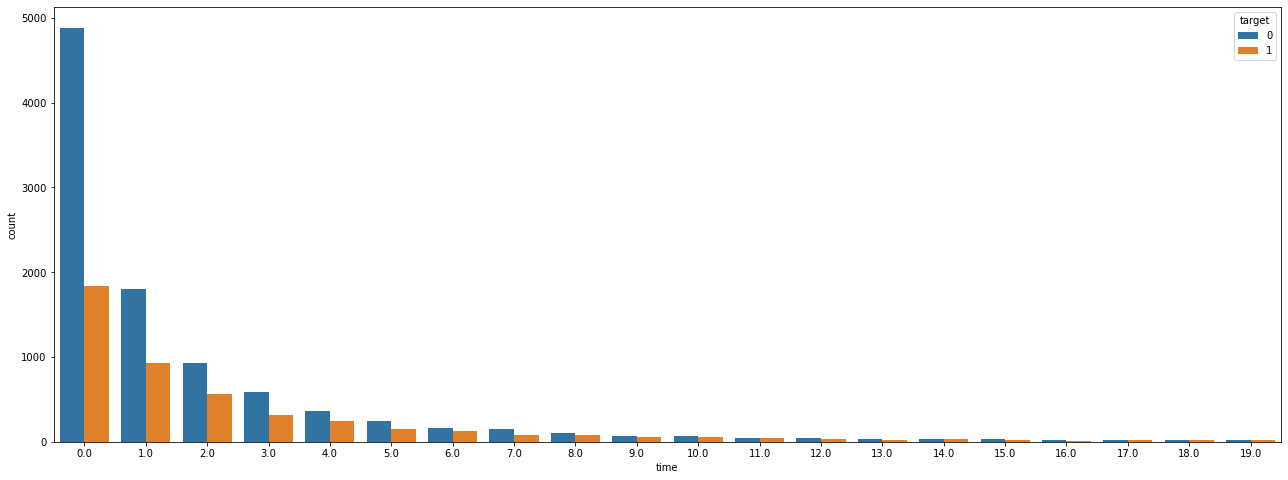

In [229]:
plt.figure(figsize=(22, 8))
sns.countplot(x='time', hue='target', data=temp[temp.time < 20])
plt.show()

로그 기록이 많아질수록 0과 1의 비율이 비슷해지는 경향이 생깁니다.

In [230]:
pd.pivot_table(temp, index="time", values="target").head(20)

,target
time,
0.0,0.272808
1.0,0.340643
2.0,0.376667
3.0,0.354696
4.0,0.399015
5.0,0.375315
6.0,0.422680
7.0,0.342105
8.0,0.422460


In [231]:
train_q

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12,year,month,day,hour,minute
0,2020-11-29 09:00:00,10000,05.15.2138,0.0,0,0.0,0.0,0,0.0,0.0,0.0,4.0,0,0,2020,11,29,09,00
1,2020-11-29 09:00:00,10000,05.15.2138,0.0,0,0.0,0.0,0,0.0,0.0,0.0,4.0,0,0,2020,11,29,09,00
2,2020-11-29 09:00:00,10000,05.15.2138,0.0,0,0.0,0.0,0,0.0,0.0,0.0,4.0,0,0,2020,11,29,09,00
3,2020-11-29 09:00:00,10000,05.15.2138,0.0,0,0.0,0.0,0,0.0,0.0,0.0,4.0,0,0,2020,11,29,09,00
4,2020-11-29 09:00:00,10000,05.15.2138,0.0,0,0.0,0.0,0,0.0,0.0,0.0,4.0,0,0,2020,11,29,09,00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828619,2020-11-24 03:00:00,24997,04.22.1778,0.0,0,0.0,1.0,0,0.0,0.0,0.0,17.0,0,0,2020,11,24,03,00
828620,2020-11-24 03:00:00,24997,04.22.1778,0.0,0,0.0,0.0,0,0.0,0.0,0.0,17.0,0,0,2020,11,24,03,00
828621,2020-11-24 03:00:00,24997,04.22.1778,0.0,0,0.0,3.0,0,0.0,0.0,0.0,17.0,0,0,2020,11,24,03,00
828622,2020-11-24 03:00:00,24997,04.22.1778,0.0,0,0.0,0.0,0,0.0,0.0,0.0,17.0,0,0,2020,11,24,03,00


시간이 또 있으니까, 시간을 가지고 무언가를 만들어볼 수 있을까요?

유저별로 로그가 가장 많이 기록된 시간이 따로 있을까요?

In [232]:
train_q.hour = train_q.hour.astype('int8')

In [233]:
temp = train_q[['user_id', 'hour']].drop_duplicates().groupby('user_id').std().round(1)

In [234]:
temp2 = pd.concat([train_b_p.set_index('user_id'), temp], axis=1).fillna(0)

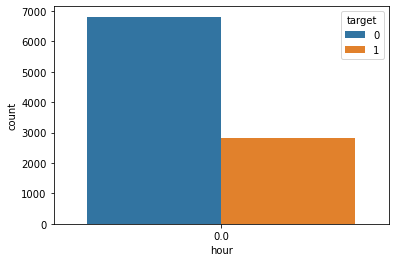

In [235]:
sns.countplot(data=temp2[temp2.hour < 0.1], x='hour', hue='target')
plt.show()

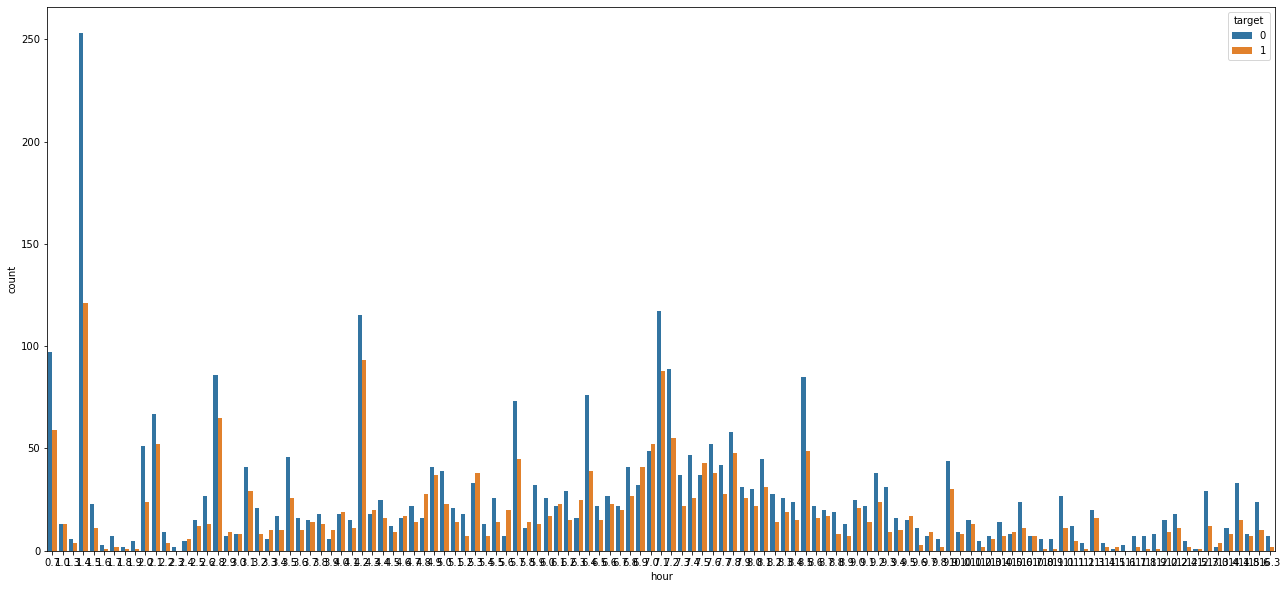

In [236]:
plt.figure(figsize=(22, 10))
sns.countplot(data=temp2[temp2.hour > 0.1], x='hour', hue='target')
plt.show()

응, 별 의미 없어보이구영

In [237]:
train_q

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12,year,month,day,hour,minute
0,2020-11-29 09:00:00,10000,05.15.2138,0.0,0,0.0,0.0,0,0.0,0.0,0.0,4.0,0,0,2020,11,29,9,00
1,2020-11-29 09:00:00,10000,05.15.2138,0.0,0,0.0,0.0,0,0.0,0.0,0.0,4.0,0,0,2020,11,29,9,00
2,2020-11-29 09:00:00,10000,05.15.2138,0.0,0,0.0,0.0,0,0.0,0.0,0.0,4.0,0,0,2020,11,29,9,00
3,2020-11-29 09:00:00,10000,05.15.2138,0.0,0,0.0,0.0,0,0.0,0.0,0.0,4.0,0,0,2020,11,29,9,00
4,2020-11-29 09:00:00,10000,05.15.2138,0.0,0,0.0,0.0,0,0.0,0.0,0.0,4.0,0,0,2020,11,29,9,00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828619,2020-11-24 03:00:00,24997,04.22.1778,0.0,0,0.0,1.0,0,0.0,0.0,0.0,17.0,0,0,2020,11,24,3,00
828620,2020-11-24 03:00:00,24997,04.22.1778,0.0,0,0.0,0.0,0,0.0,0.0,0.0,17.0,0,0,2020,11,24,3,00
828621,2020-11-24 03:00:00,24997,04.22.1778,0.0,0,0.0,3.0,0,0.0,0.0,0.0,17.0,0,0,2020,11,24,3,00
828622,2020-11-24 03:00:00,24997,04.22.1778,0.0,0,0.0,0.0,0,0.0,0.0,0.0,17.0,0,0,2020,11,24,3,00


## 변수 만들어주기

### 1차-유저별로 각 퀄리티의 std는 어느정도인가?

In [54]:
train_qual_std = train_q.groupby(['user_id']).std()
test_qual_std = test_q.groupby(['user_id']).std()

In [55]:
train_qual_std.shape, test_qual_std.shape

((8281, 11), (8268, 11))

### 4차-유저별로 퀄리티 로그가 몇 번이나 기록되었을까?

In [56]:
train_qual_log = train_q.groupby('user_id')['time'].count()/12
test_qual_log = test_q.groupby('user_id')['time'].count()/12

## train_p를 합쳐서 확인해보기

In [26]:
temp = train_e.groupby(['user_id', 'fwver'])['errcode'].count().reset_index()

In [27]:
temp_2 = temp[temp.errcode != 0]

In [28]:
temp_3 = pd.merge(train_e, train_b_p, how='outer', on=['user_id'])

In [29]:
temp_4 = temp_3.groupby(['fwver', 'user_id'])['target'].max().reset_index()

In [30]:
temp_5 = temp_3.groupby(['model_nm', 'user_id'])['target'].max().reset_index()

In [31]:
temp_4.groupby('fwver').sum()

,user_id,target
fwver,,
03.11.1149,262492500,0.0
03.11.1167,262492500,141.0
04.16.3553,262492500,1314.0
04.16.3571,262492500,295.0
04.22.1684,262492500,28.0
04.22.1750,262492500,1630.0
04.22.1778,262492500,1586.0
04.33.1149,262492500,112.0
04.33.1171,262492500,1.0


In [32]:
temp_5.groupby('model_nm').sum()

,user_id,target
model_nm,,
model_0,262492500,1637.0
model_1,262492500,1318.0
model_2,262492500,1744.0
model_3,262492500,720.0
model_4,262492500,141.0
model_5,262492500,20.0
model_7,262492500,32.0
model_8,262492500,22.0
model_6,262492500,9.0


중복값이 많긴 하지만, 불편 신고한 유저들이 사용한 fwver과 model의 비중을 알 수 있습니다. 특정 model과 fwver에 몰려 있다는 것을 알 수 있습니다.<br>
베이스코드가 errtype으로만 80의 성능을 낸 이유가 있습니다. errtype의 발생으로도 이렇게 설명이 가능합니다.<br>
그렇다면 이제 나머지 5%를 맞출 수 있는 원인을 찾아줘야겠습니다.

# Train & Predict

### Base set

In [313]:
X = train_e.groupby(['user_id', 'errtype'])['errcode'].count().unstack().fillna(0)
y = test_e.groupby(['user_id', 'errtype'])['errcode'].count().unstack().fillna(0)

In [314]:
# 하나 사라진 유저를 채워주는 코드입니다.
y = y.reindex(pd.RangeIndex(y.index.max() + 1)).ffill(0)[30000:]

In [315]:
X.shape, y.shape

((15000, 41), (14999, 41))

### 1차, 2차, 만들어 둔 시리즈들

train_err_count, train_fwver_count, train_model_count, train_qual_std

test_err_count, test_fwver_count, test_model_count, test_qual_std

In [316]:
X = pd.concat([X, train_err_count, train_fwver_count, train_model_count, train_qual_std], axis=1).fillna(0)
X.shape

(15000, 55)

In [317]:
y = pd.concat([y, test_err_count, test_fwver_count, test_model_count, test_qual_std], axis=1).fillna(0)
y.shape

(14999, 55)

### 3차, 새로 만든 시리즈 추가

train_err_conn, train_err_robot, train_err_and

In [318]:
#X = pd.concat([X, train_specific_error], axis=1).fillna(0)
#y = pd.concat([y, test_specific_error], axis=1).fillna(0)

In [319]:
# 변수 선택을 위해서 하나씩 추가한 모델을 학습해보겠습니다.
#X_conn = X.drop(['err_robot', 'err_and'], axis=1)
#X_robot = X.drop(['err_conn', 'err_and'], axis=1)
#X_and = X.drop(['err_robot', 'err_conn'], axis=1)

#y_conn = y.drop(['err_robot', 'err_and'], axis=1)
#y_robot = y.drop(['err_conn', 'err_and'], axis=1)
#y_and = y.drop(['err_robot', 'err_conn'], axis=1)

결과적으로 and만 비슷한 성능을 냈고, 나머지 변수들은 성능이 떨어졌습니다.

기각

### 4차추가

train_qual_log

In [320]:
X = pd.concat([X, train_qual_log], axis=1).fillna(0)
y = pd.concat([y, test_qual_log], axis=1).fillna(0)

In [321]:
X.shape, y.shape

((15000, 56), (14999, 56))

### 5차 추가

In [186]:
# X_conn = pd.concat([X, train_errconn_onehot], axis=1).fillna(0)
# y_conn = pd.concat([y, test_errconn_onehot], axis=1).fillna(0)

In [187]:
# X_and = pd.concat([X, train_errand_onehot], axis=1).fillna(0)
# y_and = pd.concat([y, test_errand_onehot], axis=1).fillna(0)

In [188]:
# X_robot = pd.concat([X, train_errrobot_onehot], axis=1).fillna(0)
# y_robot = pd.concat([y, test_errrobot_onehot], axis=1).fillna(0)

In [189]:
# X_and_robot = pd.concat([X, train_errand_onehot, train_errrobot_onehot], axis=1).fillna(0)
# y_and_robot = pd.concat([y, test_errand_onehot, test_errrobot_onehot], axis=1).fillna(0)

In [190]:
# X_and_robot.columns = [           1,            2,            3,            4,            5,
#                   6,            7,            8,            9,           10,
#                  11,           12,           13,           14,           15,
#                  16,           17,           18,           19,           20,
#                  21,           22,           23,           24,           25,
#                  26,           27,           28,           30,           31,
#                  32,           33,           34,           35,           36,
#                  37,           38,           39,           40,           41,
#                  42,    'errcode',      'fwver',   'model_nm',  'quality_0',
#         'quality_1',  'quality_2',  'quality_5',  'quality_6',  'quality_7',
#         'quality_8',  'quality_9', 'quality_10', 'quality_11', 'quality_12',
#              'time',    'errand',    'errrobot']

In [191]:
# y_and_robot.columns = [           1,            2,            3,            4,            5,
#                   6,            7,            8,            9,           10,
#                  11,           12,           13,           14,           15,
#                  16,           17,           18,           19,           20,
#                  21,           22,           23,           24,           25,
#                  26,           27,           28,           30,           31,
#                  32,           33,           34,           35,           36,
#                  37,           38,           39,           40,           41,
#                  42,    'errcode',      'fwver',   'model_nm',  'quality_0',
#         'quality_1',  'quality_2',  'quality_5',  'quality_6',  'quality_7',
#         'quality_8',  'quality_9', 'quality_10', 'quality_11', 'quality_12',
#              'time',    'errand',    'errrobot']

### 6차 추가

In [322]:
# 살아남은 애들
X = pd.concat([X, train_errcode_33, train_errcode_23, train_errcode_34], axis=1).fillna(0)
y = pd.concat([y, test_errcode_33, test_errcode_23, test_errcode_34], axis=1).fillna(0)

In [323]:
X.shape, y.shape

((15000, 73), (14999, 73))

In [193]:
# X_31 = pd.concat([X, train_errcode_31], axis=1).fillna(0)
# y_31 = pd.concat([y, test_errcode_31], axis=1).fillna(0)

In [113]:
# X_42 = pd.concat([X, train_errcode_42], axis=1).fillna(0)
# y_42 = pd.concat([y, test_errcode_42], axis=1).fillna(0)

In [114]:
# 17호
# X_17 = pd.concat([X, train_errcode_17], axis=1).fillna(0)
# y_17 = pd.concat([y, test_errcode_17], axis=1).fillna(0)

In [115]:
# 23호
# X_23 = pd.concat([X, train_errcode_23], axis=1).fillna(0)
# y_23 = pd.concat([y, test_errcode_23], axis=1).fillna(0)

In [116]:
# 23호
# X_33 = pd.concat([X, train_errcode_33], axis=1).fillna(0)
# y_33 = pd.concat([y, test_errcode_33], axis=1).fillna(0)

In [117]:
# # 40호
# X_40 = pd.concat([X, train_errcode_40], axis=1).fillna(0)
# y_40 = pd.concat([y, test_errcode_40], axis=1).fillna(0)

In [118]:
# # 14호
# X_14 = pd.concat([X, train_errcode_14], axis=1).fillna(0)
# y_14 = pd.concat([y, test_errcode_14], axis=1).fillna(0)

In [119]:
# # 37호
# X_37 = pd.concat([X, train_errcode_37], axis=1).fillna(0)
# y_37 = pd.concat([y, test_errcode_37], axis=1).fillna(0)

In [120]:
# # 7호
# X_7 = pd.concat([X, train_errcode_7], axis=1).fillna(0)
# y_7 = pd.concat([y, test_errcode_7], axis=1).fillna(0)

In [121]:
# # 14호
# X_all = pd.concat([X, train_errcode_37, train_errcode_40], axis=1).fillna(0)
# y_all = pd.concat([y, test_errcode_37, test_errcode_40], axis=1).fillna(0)

In [122]:
{4, 6, 34}

{4, 6, 34}

In [123]:
# # 4호
# X_4 = pd.concat([X, train_errcode_4], axis=1).fillna(0)
# y_4 = pd.concat([y, test_errcode_4], axis=1).fillna(0)

In [124]:
# # 6호
# X_6 = pd.concat([X, train_errcode_6], axis=1).fillna(0)
# y_6 = pd.concat([y, test_errcode_6], axis=1).fillna(0)

In [125]:
# # 34호
# X_34 = pd.concat([X, train_errcode_34], axis=1).fillna(0)
# y_34 = pd.concat([y, test_errcode_34], axis=1).fillna(0)

In [126]:
# # 14호
# X_all = pd.concat([X, train_errcode_37, train_errcode_40], axis=1).fillna(0)
# y_all = pd.concat([y, test_errcode_37, test_errcode_40], axis=1).fillna(0)

In [203]:
# # 5
# X_38= pd.concat([X, train_errcode_38], axis=1).fillna(0)
# y_38= pd.concat([y, test_errcode_38], axis=1).fillna(0)

In [324]:
# # 32
# X_32_79= pd.concat([X, train_errcode_32_79], axis=1).fillna(0)
# y_32_79= pd.concat([y, test_errcode_32_79], axis=1).fillna(0)

# # 32
# X_32_80= pd.concat([X, train_errcode_32_80], axis=1).fillna(0)
# y_32_80= pd.concat([y, test_errcode_32_80], axis=1).fillna(0)

In [346]:
# 3
X_3= pd.concat([X, train_errcode_3], axis=1).fillna(0)
y_3= pd.concat([y, test_errcode_3], axis=1).fillna(0)

## 오버샘플링

SMOTE 기법을 활용하며, 적용후에 형변환을 해주어야 합니다.

In [454]:
print("Before OverSampling, counts of label '0': {}".format(sum(train_b_p.target==0)))
print("Before OverSampling, counts of label '1': {}".format(sum(train_b_p.target==1)))

Before OverSampling, counts of label '0': 10000
Before OverSampling, counts of label '1': 5000


In [460]:
sm = BorderlineSMOTE(random_state=42)
X_res, train_b_p_res = sm.fit_sample(X, train_b_p.target)

print('After OverSampling, the shape of train_X: {}'.format(X_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(train_b_p_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(train_b_p_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(train_b_p_res==0)))

After OverSampling, the shape of train_X: (20000, 56)
After OverSampling, the shape of train_y: (20000,) 

After OverSampling, counts of label '1': 10000
After OverSampling, counts of label '0': 10000


## Model

In [331]:
#------------------------------------------------------------
# validation auc score를 확인하기 위해 정의
def f_pr_auc(probas_pred, y_true):
    labels=y_true.get_label()
    p, r, _ = precision_recall_curve(labels, probas_pred)
    score=auc(r,p) 
    return "pr_auc", score, True
#------------------------------------------------------------


def s_fold_train_pred(train_x, train_y):
    import lightgbm as lgb

    # Train
    models     = []
    recalls    = []
    precisions = []
    auc_scores   = []
    threshold = 0.5
    # 파라미터 설정
    params =      {
                    'boosting_type' : 'gbdt',
                    'objective'     : 'binary',
                    'metric'        : 'auc',
                    'learning_rate' : 0.027,
                    'seed': 42
                    }
    #-------------------------------------------------------------------------------------
    # 5 Kfold cross validation
    s_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)    

    for train_idx, val_idx in s_fold.split(train_x, train_y):

        # split train, validation set
        X = train_x.iloc[train_idx]
        y = train_y.iloc[train_idx]
        valid_x = train_x.iloc[val_idx]
        valid_y = train_y.iloc[val_idx]

        d_train= lgb.Dataset(X, y)
        d_val  = lgb.Dataset(valid_x, valid_y)

        #run traning
        model = lgb.train(
                            params,
                            train_set       = d_train,
                            num_boost_round = 10000,
                            valid_sets      = d_val,
                            feval           = f_pr_auc,
                            verbose_eval    = 100, 
                            early_stopping_rounds = 300
                           )

        # cal valid prediction
        valid_prob = model.predict(valid_x)
        valid_pred = np.where(valid_prob > threshold, 1, 0)

        # cal scores
        recall    = recall_score(    valid_y, valid_pred)
        precision = precision_score( valid_y, valid_pred)
        auc_score = roc_auc_score(   valid_y, valid_prob)

        # append scores
        models.append(model)
        recalls.append(recall)
        precisions.append(precision)
        auc_scores.append(auc_score)

        print('==========================================================')
        
    return models, auc_scores, recalls, precisions

In [128]:
# loss 비교를 위해 지우지 않습니다.
# 최고점 모델입니다.
models, auc_scores, _, _ = s_fold_train_pred(X, train_b_p.target)
print(np.mean(auc_scores))

[LightGBM] [Info] Number of positive: 4000, number of negative: 8000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8404
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.825918	valid_0's pr_auc: 0.741626
[200]	valid_0's auc: 0.828542	valid_0's pr_auc: 0.749595
Early stopping, best iteration is:
[169]	valid_0's auc: 0.828346	valid_0's pr_auc: 0.750048
[LightGBM] [Info] Number of positive: 4000, number of negative: 8000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Li

In [347]:
# 학습용
models, auc_scores, _, _ = s_fold_train_pred(X_3, train_b_p.target)
print(np.mean(auc_scores))

[LightGBM] [Info] Number of positive: 4000, number of negative: 8000
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8469
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 300 rounds
[100]	valid_0's auc: 0.826462	valid_0's pr_auc: 0.742489
[200]	valid_0's auc: 0.827069	valid_0's pr_auc: 0.747702
[300]	valid_0's auc: 0.826928	valid_0's pr_auc: 0.746205
[400]	valid_0's auc: 0.825796	valid_0's pr_auc: 0.746154
Early stopping, best iteration is:
[135]	valid_0's auc: 0.827554	valid_0's pr_auc: 0.746708
[LightGBM] [Info] Number of positive: 4000, number of negat

In [295]:
# 0.8291028 -> 3번에서 0 빼고 2개만 넣었을 때.
# 0.8291045 -> 3번 다 넣었을 때.

# 0.8294180 -> 32번 80만 썼을 때. -> 하지만 리더보드는 떨어졌음. 오버피팅 되기 시작하는 중.
# 0.8287242 -> 32번 79만
# 0.8290839 -> 32번 2개 썼을 때.

In [220]:
# 여기서 새로운 사실을 발견합니다. 모델의 성능을 높이는 33호, 23호, 34호가 유니크 밸류가 많은 변수들입니다. 심지어 34호는 많은 유저에게 발견된 에러가 아니지만 성능을 높였습니다.
# 즉 단순히 에러타입의 카운트만으로는 설명할 수 없는 정보를 보전해준 것입니다.
# 이런 측면에서는 모수는 적더라도 유니크 밸류가 많은 에러타입들이 성능을 높여줄 수도 있을 것입니다.


# 0.82739084 add 슬라이싱, 4개로 묶어준 5호.
# 0.8288978  add 34호 -> 너무 높은데?
# 0.82753294 add 6호
# 0.82589145 add 4호
#---------------------------------------------------
# 0.8275499  add 37호, 40호 = 기각
# 0.8278117  add 40호, 14호 = 기각
# 0.82786755 add 14호 ->>>>>>>> 최고점. 리더보드 기각.
# 0.82774835 add 37호
# 0.82773244 add 40호
# 0.82664045 add 7호 = 기각
#-----------------------------------------------
# 0.82771425 33호, 17호, 23호 = 기각
# 0.82772905 33호, 23호 ->>>>>>>최고점. 현재 리더보드 최고점.
# 0.82463510 23호
# 0.82416839 17호, 23호
# 0.82411075 17호, 33호
# 0.82409524 33호
# 0.82064539 17호

In [348]:
pred_y_list = []
for model in models:
    pred_y = model.predict(y_3)
    pred_y_list.append(pred_y.reshape(-1,1))
    
pred_ensemble = np.mean(pred_y_list, axis = 0)

In [349]:
submission.problem = pred_ensemble
submission

,user_id,problem
0,30000,0.917339
1,30001,0.289391
2,30002,0.528682
3,30003,0.671640
4,30004,0.863001
...,...,...
14994,44994,0.181981
14995,44995,0.338955
14996,44996,0.788515
14997,44997,0.876590


In [351]:
#submission.to_csv(r'C:\Users\Wyatt\wyatt37/Comp/LG_edge_detect/king/submission/king_210121_2_fc-param-3rd.csv', index=False)

# Evaluation

### 1,2차 합본

0.8075 -> 0.8161로 상승했습니다. 그래도 0.9% 오른거면 꽤나 올랐네요!

### 1,2차 합본 파라미터 튜닝

파라미터 튜닝을 해줬는데, 0.8161 -> 0.8222	로 상승했습니다. lgbm 만세! 0.6% 올랐습니다.

바꾼 파라미터

1. lr {'default' : 0.027}
2. num_boost_round {1000:10000}
3. early_stopping_rounds {3 :100}

미세하게 많이 개선하도록 바꿨습니다.

### 3차 합본

specific error count 를 넣으니 성능이 오히려 떨어졌습니다.

0.8217로 큰 차이는 없으나 Loss를 따라가는 것 같습니다.

하나씩 줄여가면서 다시 학습을 시켜보겠습니다.

하나씩 학습시켜보았으나, 기존의 로스를 넘는 변수는 없었음

### 4차 합본

0.8222 -> 0.8228 로 아주 미세하게 상승 0.0006 상승했습니다.

### 5차 합본

0.8228 -> 0.8230 으로 아주 미세하게 0.0002 상승했습니다.

conn, robot 전부 떨어졌지만, android만 올랐습니다.

### 오버샘플링

smote-b 로 오버샘플링을 해주었으나, 점수는 떨어졌습니다. 로스보고 깜짝 놀랐네요.

### 6차 합본

31호와 41호를 더해봤지만, 41호는 로스가 좋지 않아 기각하였고, 31호는 제출했으나 오르지 않았습니다.

33호에서 0.8230 -> 0.8260 으로 상승했습니다. 효과가 있는 것 같습니다.	0.003 상승

17호는 노이즈입니다. 33호와 23호를 동시에 넣었을 때 가장 로스가 적었고, 성능이 대폭 올랐습니다. 0.8260 -> 0.8323 으로 0.0063이나 올랐습니다.

추가로 7호, 40호, 37호, 14호 까지 시험해 보았으나, 14호만 로스가 줄었음, 그러나 리더보드는 오르지 않았음.

In [150]:
def s_fold_catb_train_pred(train_x, train_y):
    import catboost as catb
    from catboost import CatBoostRegressor
    catb_reg = CatBoostRegressor()

    # Train
    models     = []
    recalls    = []
    precisions = []
    auc_scores   = []
    threshold = 0.5
    # 파라미터 설정
    params =      {
                    'boosting_type' : 'gbdt',
                    'objective'     : 'binary',
                    'metric'        : 'auc',
                    'learning_rate' : 0.027,
                    'seed': 42
                    }
    #-------------------------------------------------------------------------------------
    # 5 Kfold cross validation
    s_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)    

    for train_idx, val_idx in s_fold.split(train_x, train_y):

        # split train, validation set
        X = train_x.iloc[train_idx]
        y = train_y.iloc[train_idx]
        valid_x = train_x.iloc[val_idx]
        valid_y = train_y.iloc[val_idx]

        d_train= catb.Dataset(X, y)
        d_val  = catb.Dataset(valid_x, valid_y)

        #run traning
        model = catb.train(
                            params,
                            train_set       = d_train,
                            num_boost_round = 10000,
                            valid_sets      = d_val,
                            feval           = f_pr_auc,
                            verbose_eval    = 100, 
                            early_stopping_rounds = 100
                           )

        # cal valid prediction
        valid_prob = model.predict(valid_x)
        valid_pred = np.where(valid_prob > threshold, 1, 0)

        # cal scores
        recall    = recall_score(    valid_y, valid_pred)
        precision = precision_score( valid_y, valid_pred)
        auc_score = roc_auc_score(   valid_y, valid_prob)

        # append scores
        models.append(model)
        recalls.append(recall)
        precisions.append(precision)
        auc_scores.append(auc_score)

        print('==========================================================')
        
    return models, auc_scores, recalls, precisions

In [151]:
CatBoostClassifier?

Init signature:
CatBoostClassifier(
    iterations=None,
    learning_rate=None,
    depth=None,
    l2_leaf_reg=None,
    model_size_reg=None,
    rsm=None,
    loss_function=None,
    border_count=None,
    feature_border_type=None,
    per_float_feature_quantization=None,
    input_borders=None,
    output_borders=None,
    fold_permutation_block=None,
    od_pval=None,
    od_wait=None,
    od_type=None,
    nan_mode=None,
    counter_calc_method=None,
    leaf_estimation_iterations=None,
    leaf_estimation_method=None,
    thread_count=None,
    random_seed=None,
    use_best_model=None,
    best_model_min_trees=None,
    verbose=None,
    silent=None,
    logging_level=None,
    metric_period=None,
    ctr_leaf_count_limit=None,
    store_all_simple_ctr=None,
    max_ctr_complexity=None,
    has_time=None,
    allow_const_label=None,
    target_border=None,
    classes_count=None,
    class_weights=None,
    auto_class_weights=None,
    class_names=None,
    one_hot_max_size=Non

In [149]:
models, auc_scores, _, _ = s_fold_catb_train_pred(X, train_b_p.target)
print(np.mean(auc_scores))

AttributeError: module 'catboost' has no attribute 'Dataset'